In [1]:
import pickle
import sqlite3
import datetime 
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pyodbc
import requests
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import streamlit as st
# To make things easier later, we're also importing numpy and pandas for
# working with sample data.
import numpy as np
import matplotlib.pyplot as plt
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score,confusion_matrix, classification_report
from collections import Counter
from sklearn.multiclass import OneVsRestClassifier



In [2]:
# !conda install xgboost

In [187]:
SPOTIPY_CLIENT_ID="ba5fae975b7f45b6949824e976fbbf8a"
SPOTIPY_CLIENT_SECRET="811fe6fa3a73436292d83c891b2fa66b"
auth_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

#establish sql db engine
engine = create_engine("sqlite:///database/spotify_class.db")

In [4]:
'''function to get all the genres, playlist_ids, and playlist titles for spotify curated playlists 
associated with each genre'''

def get_genre_playlists(genre_id):
    try:
        playlist_dict={}
        for i in range (0,1000,50):
            try:
                genre_playlists = sp.category_playlists(genre_id,country='US',limit = 50,offset=i)
                time.sleep(2)
            except AttributeError:
                print('Spotify timed out... trying again...')
                genre_playlists = sp.category_playlists(genre_id,country='US',limit = 50,offset=i)
                time.sleep(2)
            
            for item in genre_playlists['playlists']['items']:
                try:
                    if item['name'] in playlist_dict:
                        playlist_dict[item['name']].update({genre_id:item['id']})
                    else:
                        playlist_dict[item['name']]= {genre_id:item['id']}
                except TypeError or spotipy.exceptions.SpotifyException:
                    print(f'{genre_id} playlists do not exists','\n')
                    continue
        for key, value in playlist_dict.items():
            if value is None:
                del d[key]
        return playlist_dict
    except spotipy.exceptions.SpotifyException:
        pass
    

In [5]:
# get_genre_playlists('pop')

In [6]:
# get df with all playlists and their IDs
def get_playlist_df(genre_id):   
    genre_playlists = get_genre_playlists(genre_id)
    playlist_df_list=[]
    try:
        new_df = pd.DataFrame.from_dict(genre_playlists,orient='index')
        try:
            new_df['genre']=new_df.columns.tolist()[0]
            new_df.columns.values[0] = "playlist_id"
            playlist_df_list.append(new_df)
        except IndexError:
            pass       
    except TypeError:
        pass
    try:
        playlist_df=pd.concat(playlist_df_list)
        playlist_df=playlist_df.reset_index()
        playlist_df=playlist_df.rename(columns={"index": "playlist_name"})
        if type(playlist_df) == None:
            pass
        else:
            return playlist_df
    except ValueError:
        pass

In [7]:
# get_playlist_df('pop')

In [8]:
def convert_to_mins(duration_ms):
    seconds = duration_ms/1000
    minutes=seconds/60
    return minutes

#get the audio features for each song of a playlist into a dataframe and then store into sql db
def get_playlist_features(genre_id):
    df=get_playlist_df(genre_id)
    list_of_playlist_ids=df['playlist_id'].tolist()
    list_of_dfs=[]
    for playlist_id in list_of_playlist_ids:                
    #             try:
        playlist_list = sp.playlist_tracks(playlist_id,additional_types=('track', ))['items']
    #             except ReadTimeout:
    #                 print('Spotify timed out... trying again...')
    #                 playlist_list = sp.playlist_tracks(playlist_id,additional_types=('track', ))['items']
    #             try:
        track_id_dict = {}
        audio_features_dict = {}
        artist_dict = {}
        for item in playlist_list:
            try:
                track_id_dict[item['track']['name']]=item['track']['id']
                artist_dict[item['track']['name']]=(item['track']['artists'][0]['name'])
            except TypeError:
                continue

        for key in track_id_dict:
            try:
                audio_features_dict[key]=sp.audio_features(track_id_dict[key])[0]
            except AttributeError:
                pass
        try:
            audio_df = pd.DataFrame.from_dict(audio_features_dict, orient='index')
            artist_df = pd.DataFrame.from_dict(artist_dict, orient='index')
            artist_df.rename(columns={0: "artist"},inplace = True)
            audio_df = audio_df.merge(artist_df,how='left',left_index=True,right_index=True)
            audio_df=audio_df.reset_index()
            audio_df=audio_df.rename(columns={"index": "song_name"}) 
            audio_df['playlist_id'] = playlist_id
            audio_df = audio_df.merge(df,how='outer',on='playlist_id')
        #     display(audio_df)
            list_of_dfs.append(audio_df)
            del artist_df
        except AttributeError:
            pass
    try:    
        final_df = pd.concat(list_of_dfs)
    except ValueError:
        pass
    try:
        final_df['duration_ms']=final_df['duration_ms'].apply(convert_to_mins)
        final_df = final_df.rename(columns={"duration_ms": "duration_mins"})
        final_df["date_pulled"]=pd.to_datetime('today').normalize()
        final_df.drop_duplicates(subset=['song_name'],inplace=True)
        final_df=final_df.reset_index(drop=True)
    except KeyError:
        pass
    final_df.to_sql('audio_features', con=engine, index=True,if_exists='append')
    return final_df


In [9]:
# sp.playlist_tracks('37i9dQZF1DX0kbJZpiYdZl',additional_types=('track', ))['items'][0]['track']['artists'][0]['name']

In [10]:
# get_playlist_features('pop')

In [11]:
def get_all_data(list_of_genre_ids):
    for genre_id in list_of_genre_ids:
        try:
            genre_df = get_playlist_features(genre_id)
            time.sleep(10)
        except TypeError:
            pass   
    return "All Data Stored in Database"


In [12]:
genre_ids=[]
for i in range(0,1000,50):
    spotify_genres=(sp.categories(country='US',limit = 50,offset=i)['categories']['items'])
    for item in spotify_genres:
        genre_ids.append(item['id'])
genre_ids

['toplists',
 'hiphop',
 'pop',
 'country',
 'rock',
 'latin',
 'workout',
 'rnb',
 'mood',
 'edm_dance',
 'indie_alt',
 'sleep',
 'inspirational',
 'regional_mexican',
 'student',
 'focus',
 'summer',
 'frequency',
 'chill',
 'decades',
 'fresh_finds',
 'equal',
 'party',
 'kids_family',
 'gaming',
 'roots',
 'kpop',
 'instrumental',
 'ambient',
 'alternative',
 'wellness',
 'pride',
 'romance',
 'in_the_car',
 'shows_with_music',
 'classical',
 'jazz',
 'soul',
 'sessions',
 'happier_than_ever',
 'at_home',
 'dinner',
 'punk',
 'sports',
 'popculture',
 'aapi_heritage_month',
 'blues',
 'arab',
 'desi',
 'radar',
 'jre_podcast',
 'callherdaddy_podcast',
 'anime',
 'thirdparty',
 'afro',
 'comedy',
 'metal',
 'caribbean',
 'funk',
 'travel',
 'play_your_part',
 'holidays']

In [13]:
len(genre_ids)

62

In [14]:
# get_all_data(genre_ids[52:])

In [15]:
genre_df = pd.read_sql(f'SELECT * FROM audio_features',engine)

In [16]:
genre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168031 entries, 0 to 168030
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             168031 non-null  int64  
 1   song_name         167905 non-null  object 
 2   danceability      167905 non-null  float64
 3   energy            167905 non-null  float64
 4   key               167905 non-null  float64
 5   loudness          167905 non-null  float64
 6   mode              167905 non-null  float64
 7   speechiness       167905 non-null  float64
 8   acousticness      167905 non-null  float64
 9   instrumentalness  167905 non-null  float64
 10  liveness          167905 non-null  float64
 11  valence           167905 non-null  float64
 12  tempo             167905 non-null  float64
 13  type              167905 non-null  object 
 14  id                167905 non-null  object 
 15  uri               167905 non-null  object 
 16  track_href        16

In [17]:
genre_df.dropna(subset=['song_name'],inplace=True)
genre_df.drop_duplicates(subset=['song_name'],inplace=True)

2021-09-03 03:30:53.811 INFO    numexpr.utils: NumExpr defaulting to 4 threads.


In [18]:
genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91865 entries, 0 to 168021
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             91865 non-null  int64  
 1   song_name         91865 non-null  object 
 2   danceability      91865 non-null  float64
 3   energy            91865 non-null  float64
 4   key               91865 non-null  float64
 5   loudness          91865 non-null  float64
 6   mode              91865 non-null  float64
 7   speechiness       91865 non-null  float64
 8   acousticness      91865 non-null  float64
 9   instrumentalness  91865 non-null  float64
 10  liveness          91865 non-null  float64
 11  valence           91865 non-null  float64
 12  tempo             91865 non-null  float64
 13  type              91865 non-null  object 
 14  id                91865 non-null  object 
 15  uri               91865 non-null  object 
 16  track_href        91865 non-null  objec

In [19]:
drop_list = ['at_home','happier_than_ever','in_the_car','wellness','instrumental','sports','regional_mexican',
            'popculture','ambient','toplists','radar','student','frequency','dinner','fresh_finds','travel',
            'pride','summer','decades','desi','equal','aapi_heritage_month','mood','chill','anime','focus',
             'gaming','inspirational','romance']

new_df = genre_df.drop('index',axis=1)
new_df.drop(new_df[new_df['genre'].isin(drop_list)].index, inplace = True)


In [20]:
new_df=new_df.reset_index(drop=True)

In [21]:
new_df.iloc[:,0:20]
drop_list = ['type','uri','track_href','analysis_url']
new_df = pd.get_dummies(new_df,columns=['mode','time_signature','key'])

In [22]:
new_df.drop(drop_list,axis=1,inplace=True)

In [23]:
new_df.drop('id',axis=1,inplace=True)

In [24]:
# new_df=new_df.astype({'class': 'int32'})

In [25]:
# count_song_df = new_df.groupby('genre')['song_name'].count()
# count_song_df=pd.DataFrame(count_song_df)
# count_song_df.sort_values('song_name')

In [26]:
genre_label_dict = {}
counter = 1
for genre in genre_ids:
    if genre not in genre_label_dict:
        genre_label_dict[genre]=counter
        counter+=1
    else:
        continue
genre_label_dict
    
    
for genre_type in new_df['genre'].unique():
    new_df.loc[new_df.genre==genre_type,"class"]=genre_label_dict[genre_type]

In [27]:
new_df

new_df = pd.get_dummies(new_df,columns=['mode','time_signature','key'])
genre_dummy = pd.get_dummies(new_df['genre'])


new_df = new_df.merge(genre_dummy, left_index=True, right_index=True)
new_df.reset_index(drop=True)

# new_df = new_df.merge(dummy_df_sig, left_index=True, right_index=True)
# new_df.reset_index(drop=True)


new_df

,song_name,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,metal,party,pop,punk,rnb,rock,roots,sleep,soul,workout
0,24 (feat. Lil Baby),0.868,0.638,-7.746,0.0736,0.146000,0.056500,0.0931,0.459,126.030,...,0,0,0,0,0,0,0,0,0,0
1,Run It Up (feat. Offset & Moneybagg Yo),0.880,0.575,-6.091,0.1630,0.415000,0.000000,0.1090,0.671,120.031,...,0,0,0,0,0,0,0,0,0,0
2,Got It On Me,0.688,0.647,-7.258,0.1900,0.008150,0.000017,0.0950,0.195,88.834,...,0,0,0,0,0,0,0,0,0,0
3,Ballin' (with Roddy Ricch),0.809,0.545,-6.678,0.0735,0.392000,0.000000,0.1510,0.244,97.008,...,0,0,0,0,0,0,0,0,0,0
4,MIDDLE CHILD,0.837,0.364,-11.713,0.2760,0.149000,0.000000,0.2710,0.463,123.984,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54761,Feel the Vibe,0.612,0.881,-6.038,0.0483,0.000616,0.242000,0.1000,0.756,125.978,...,0,0,0,0,0,0,0,0,0,0
54762,The Feeling - Honey Dijon Remix,0.758,0.872,-5.452,0.0584,0.000157,0.081900,0.0763,0.683,121.984,...,0,0,0,0,0,0,0,0,0,0
54763,Okay Okay - Remastered,0.793,0.815,-9.330,0.0927,0.277000,0.000280,0.0451,0.774,113.496,...,0,0,0,0,0,0,0,0,0,0
54764,Manhattan Skyline - JN Spirit of '77 Extended Mix,0.772,0.627,-7.795,0.0428,0.082800,0.163000,0.0541,0.901,122.011,...,0,0,0,0,0,0,0,0,0,0


In [28]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54766 entries, 0 to 54765
Data columns (total 59 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   song_name           54766 non-null  object 
 1   danceability        54766 non-null  float64
 2   energy              54766 non-null  float64
 3   loudness            54766 non-null  float64
 4   speechiness         54766 non-null  float64
 5   acousticness        54766 non-null  float64
 6   instrumentalness    54766 non-null  float64
 7   liveness            54766 non-null  float64
 8   valence             54766 non-null  float64
 9   tempo               54766 non-null  float64
 10  duration_mins       54766 non-null  float64
 11  genre               54766 non-null  object 
 12  playlist_name       54766 non-null  object 
 13  playlist_id         54766 non-null  object 
 14  date_pulled         54766 non-null  object 
 15  artist              54766 non-null  object 
 16  clas

In [29]:
new_df.columns

features = pd.concat([new_df.iloc[:,1:11],new_df.iloc[:,16:35]],axis=1)
features

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,...,key_1.0,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,key_7.0,key_8.0,key_9.0,key_10.0
0,0.868,0.638,-7.746,0.0736,0.146000,0.056500,0.0931,0.459,126.030,3.047617,...,0,1,0,0,0,0,0,0,0,0
1,0.880,0.575,-6.091,0.1630,0.415000,0.000000,0.1090,0.671,120.031,3.867467,...,0,0,0,0,0,1,0,0,0,0
2,0.688,0.647,-7.258,0.1900,0.008150,0.000017,0.0950,0.195,88.834,2.743000,...,0,1,0,0,0,0,0,0,0,0
3,0.809,0.545,-6.678,0.0735,0.392000,0.000000,0.1510,0.244,97.008,3.007250,...,0,0,0,0,0,0,1,0,0,0
4,0.837,0.364,-11.713,0.2760,0.149000,0.000000,0.2710,0.463,123.984,3.559900,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54761,0.612,0.881,-6.038,0.0483,0.000616,0.242000,0.1000,0.756,125.978,2.742750,...,0,0,0,0,0,0,0,0,0,0
54762,0.758,0.872,-5.452,0.0584,0.000157,0.081900,0.0763,0.683,121.984,3.460883,...,0,1,0,0,0,0,0,0,0,0
54763,0.793,0.815,-9.330,0.0927,0.277000,0.000280,0.0451,0.774,113.496,4.301617,...,0,1,0,0,0,0,0,0,0,0
54764,0.772,0.627,-7.795,0.0428,0.082800,0.163000,0.0541,0.901,122.011,11.116183,...,0,0,0,0,0,0,0,0,0,0


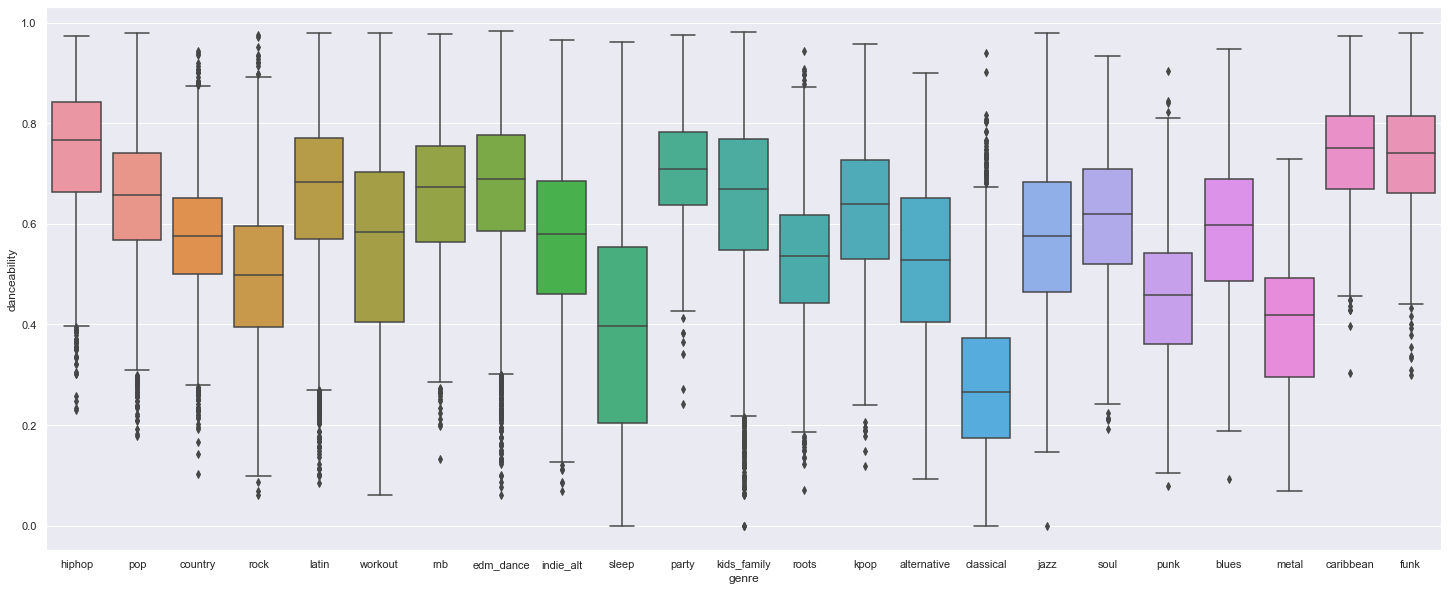

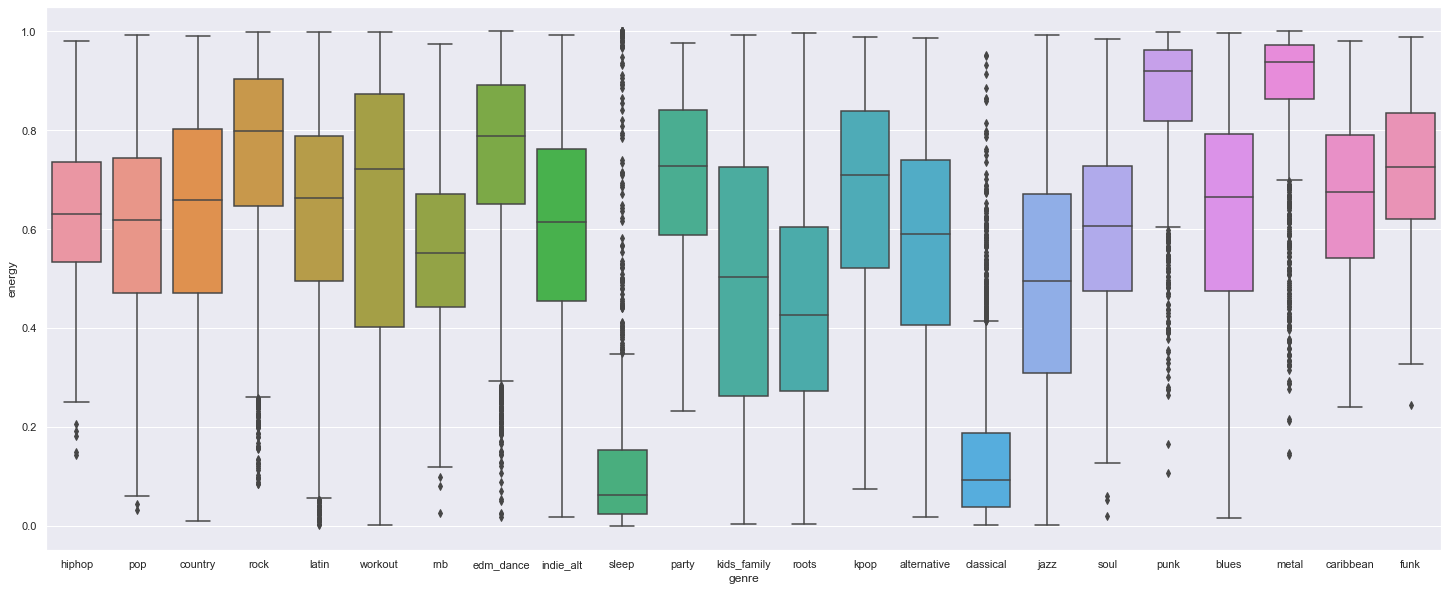

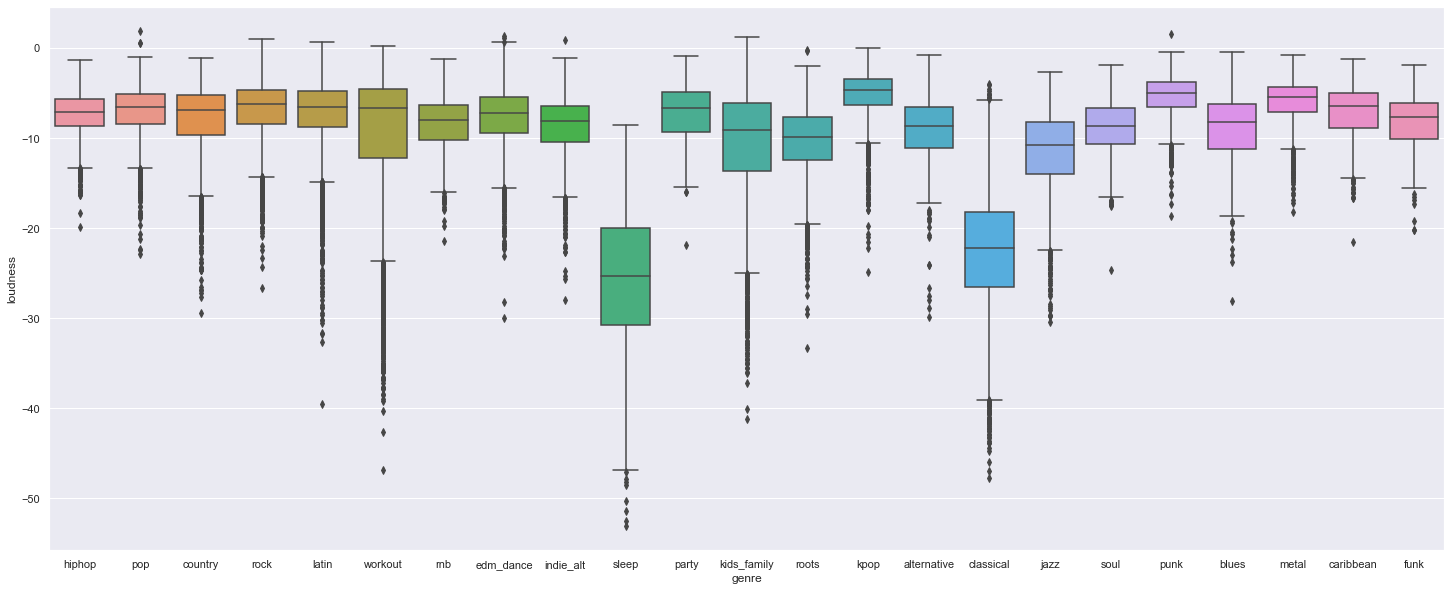

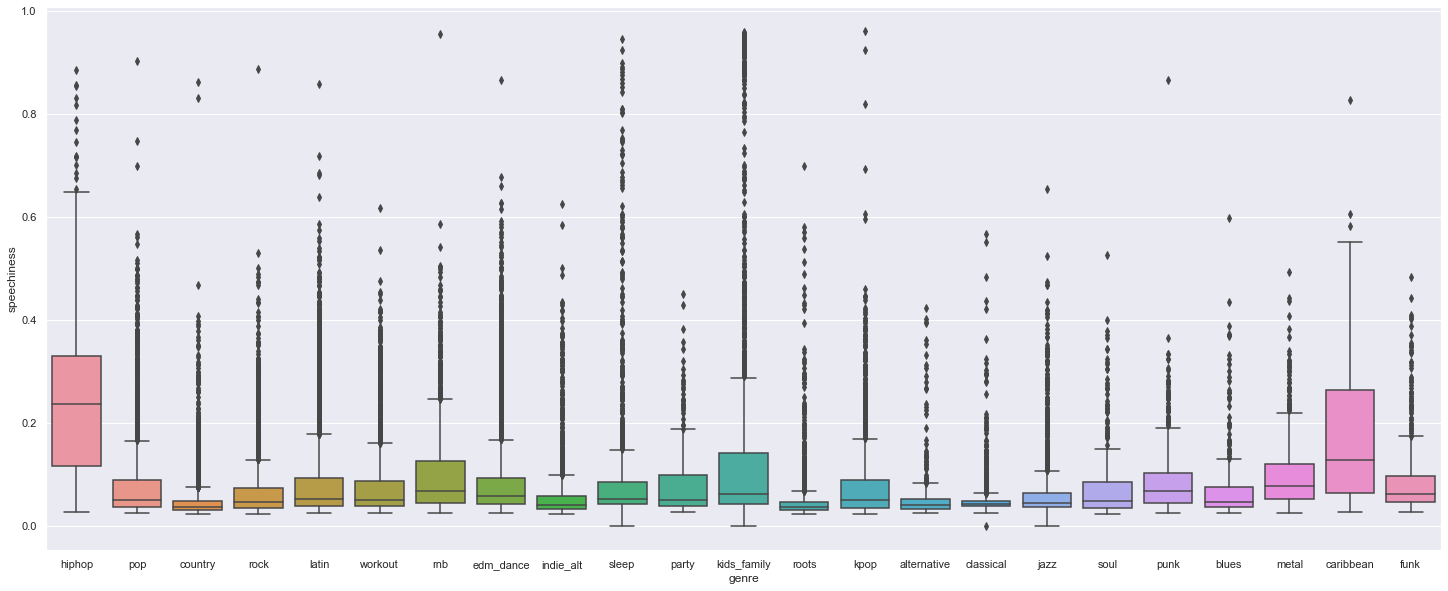

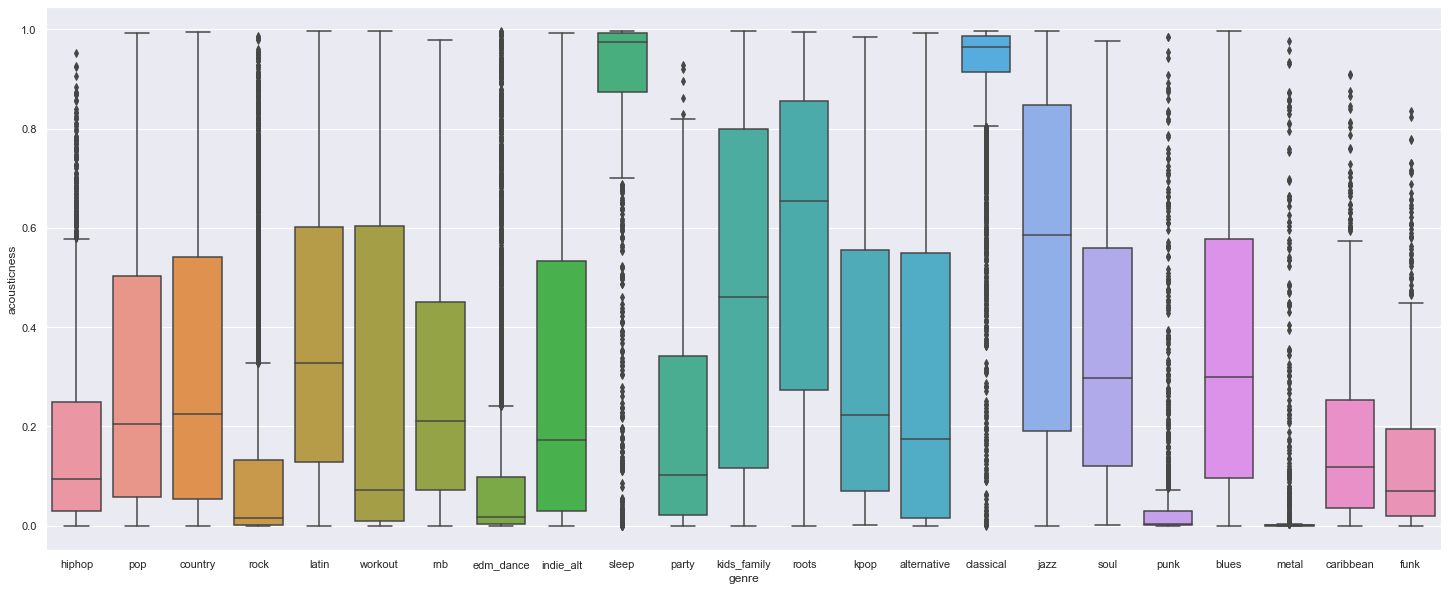

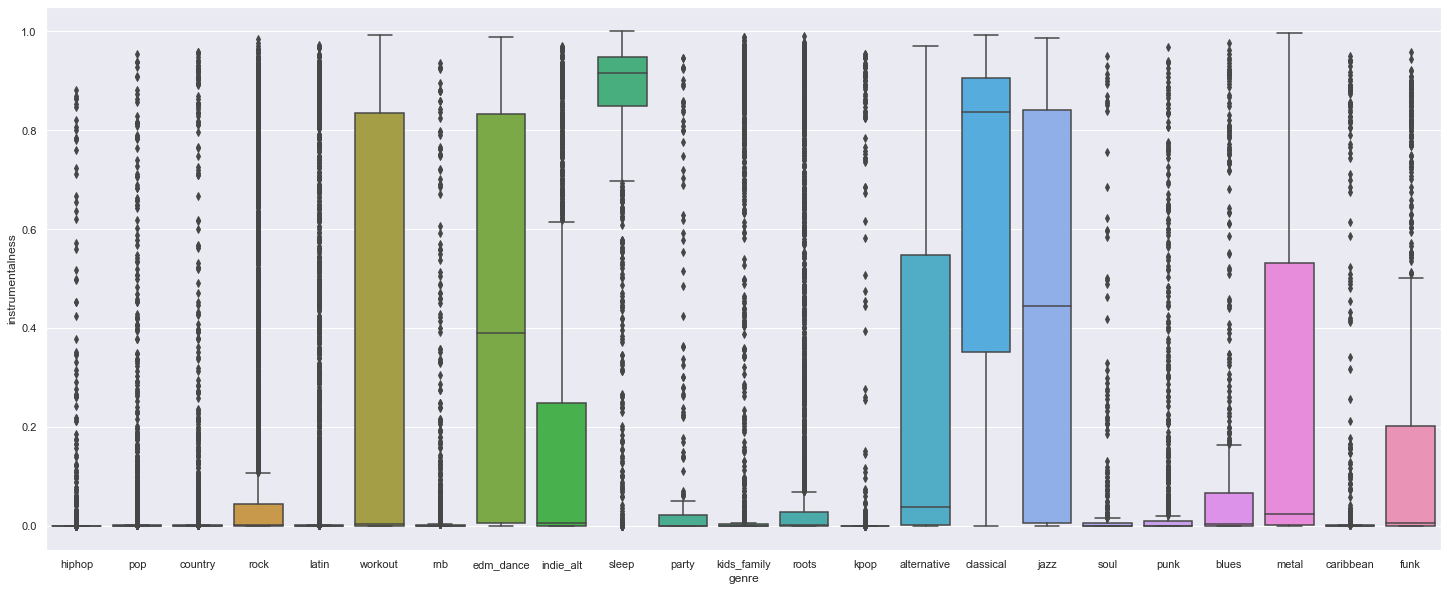

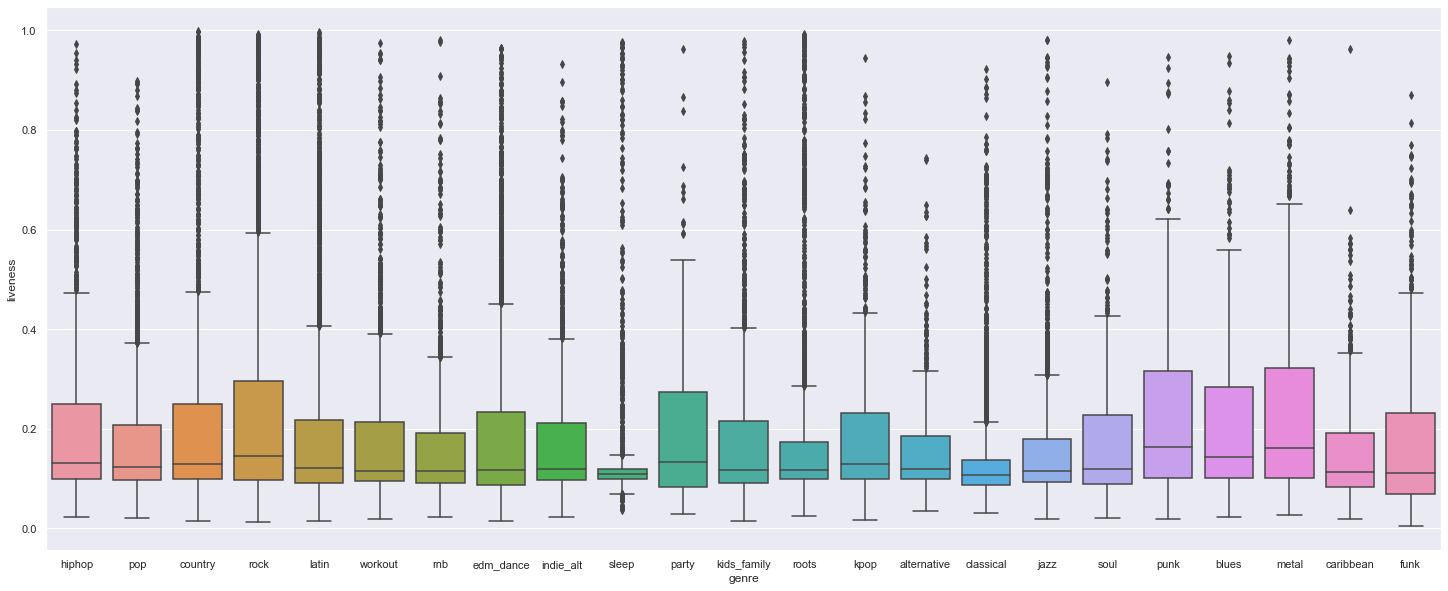

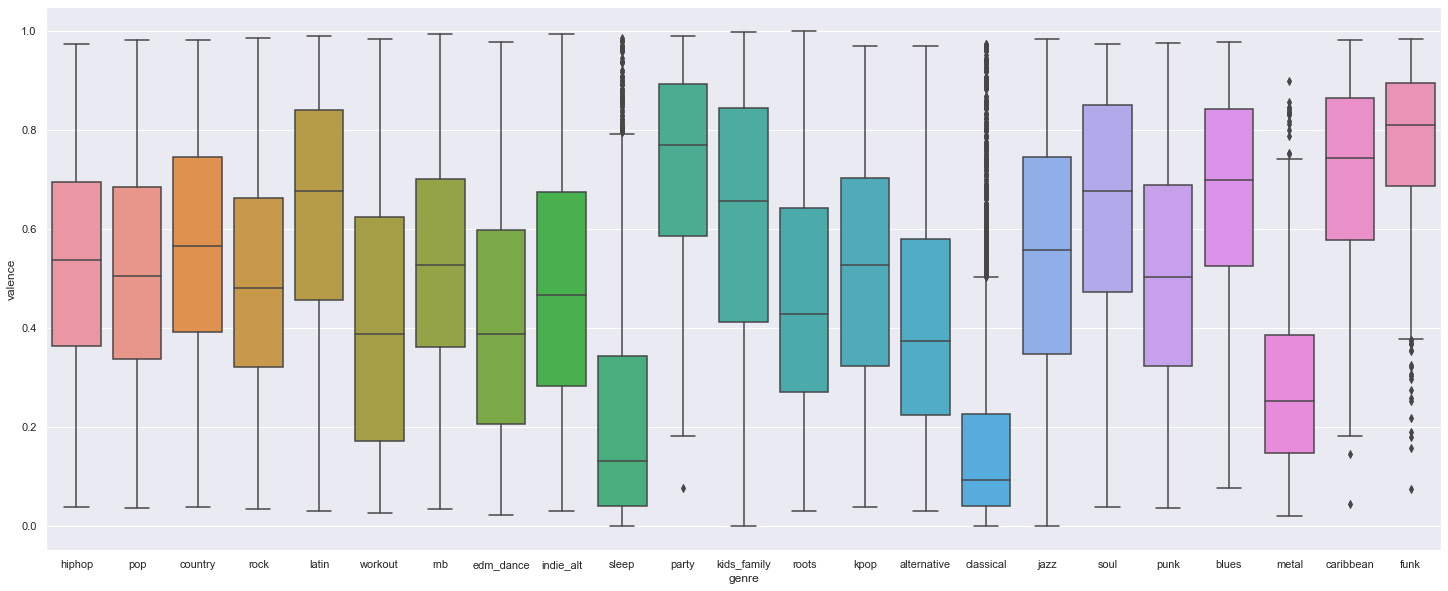

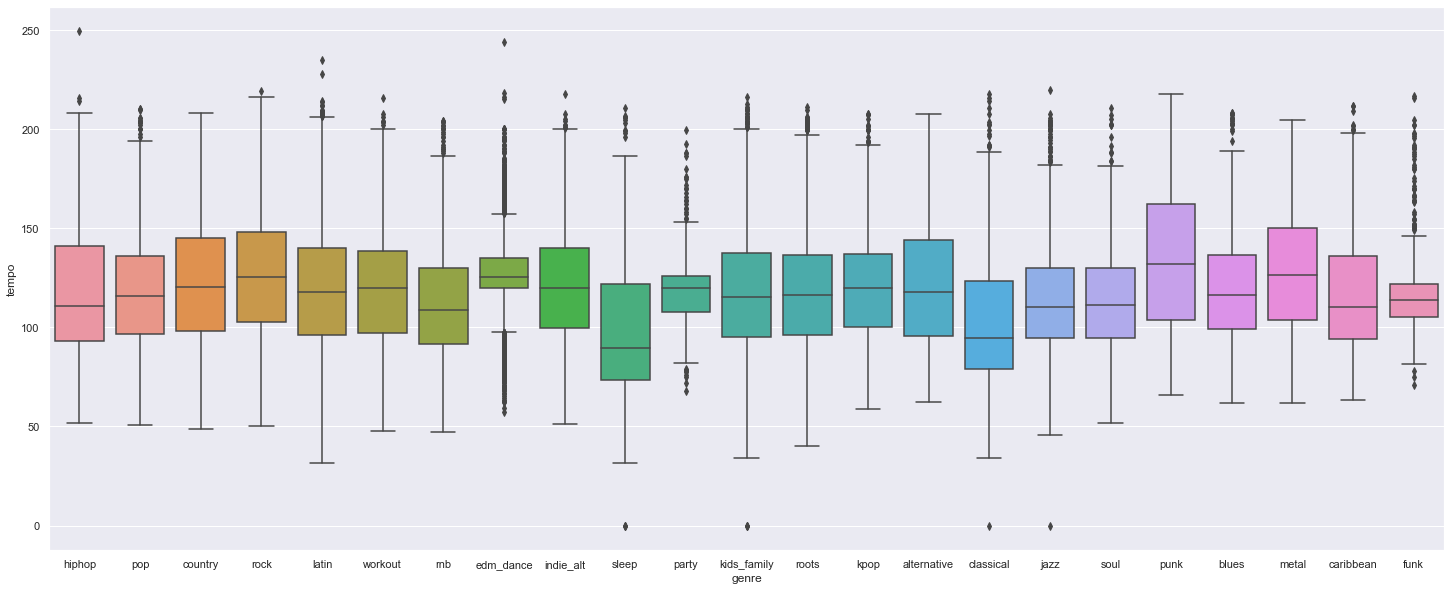

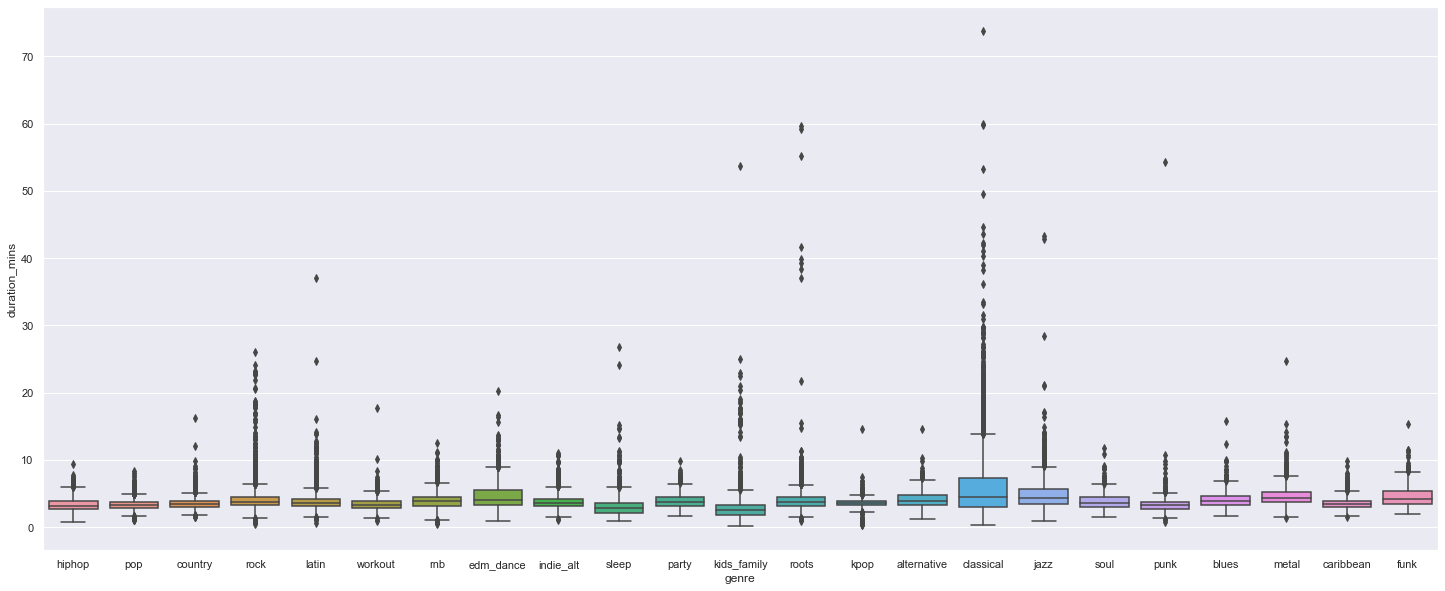

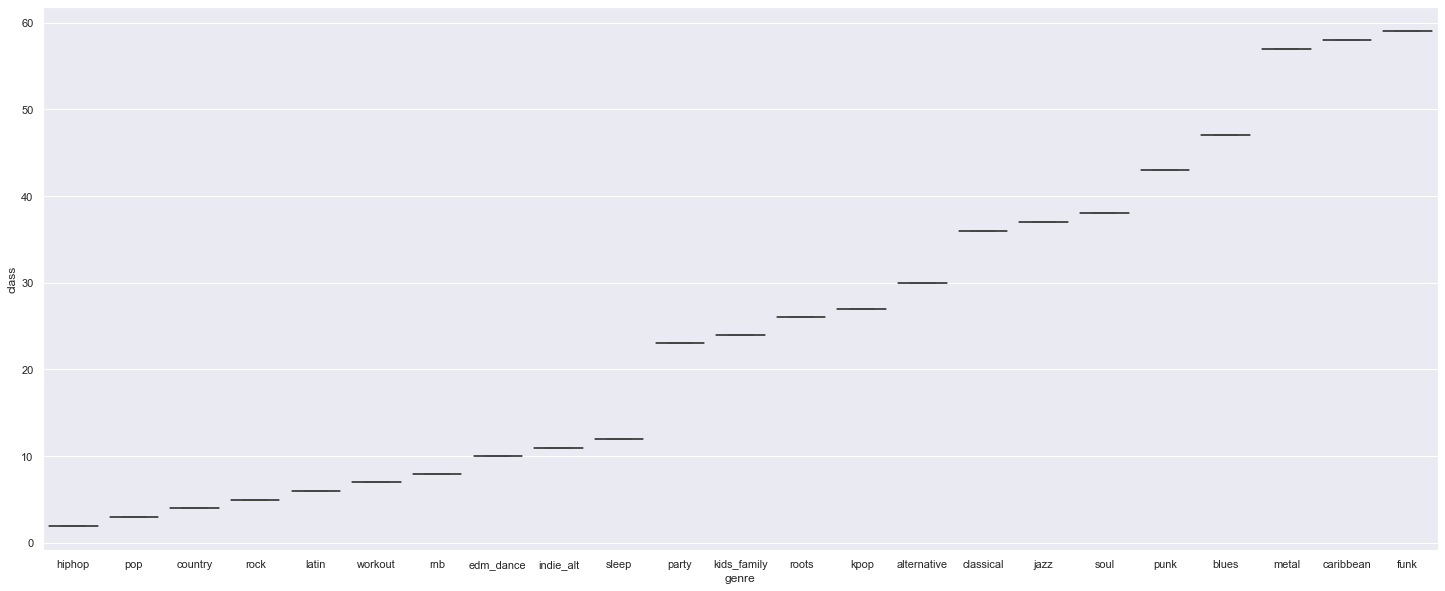

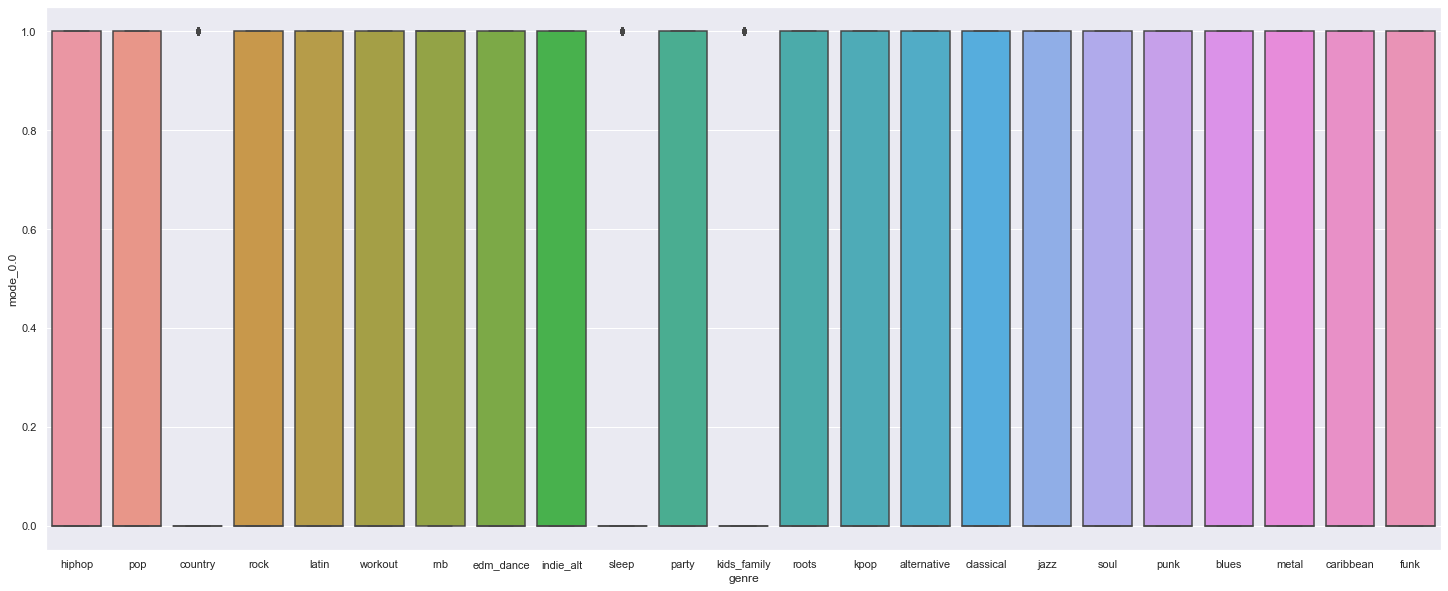

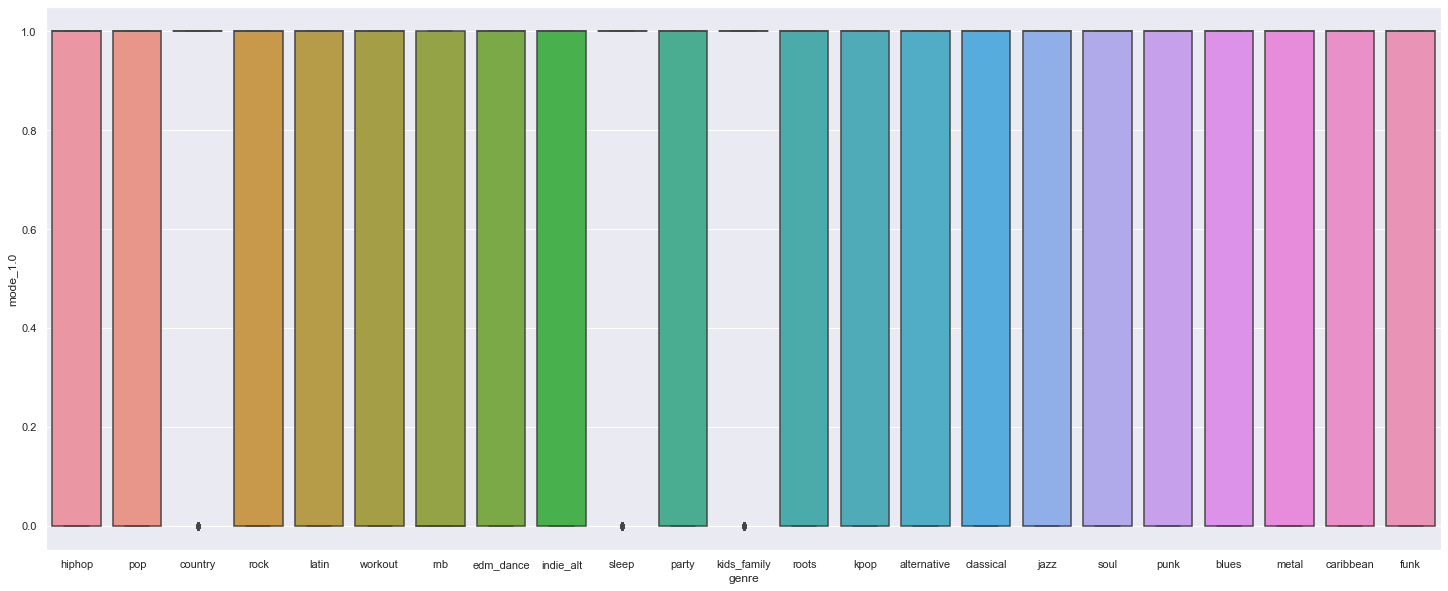

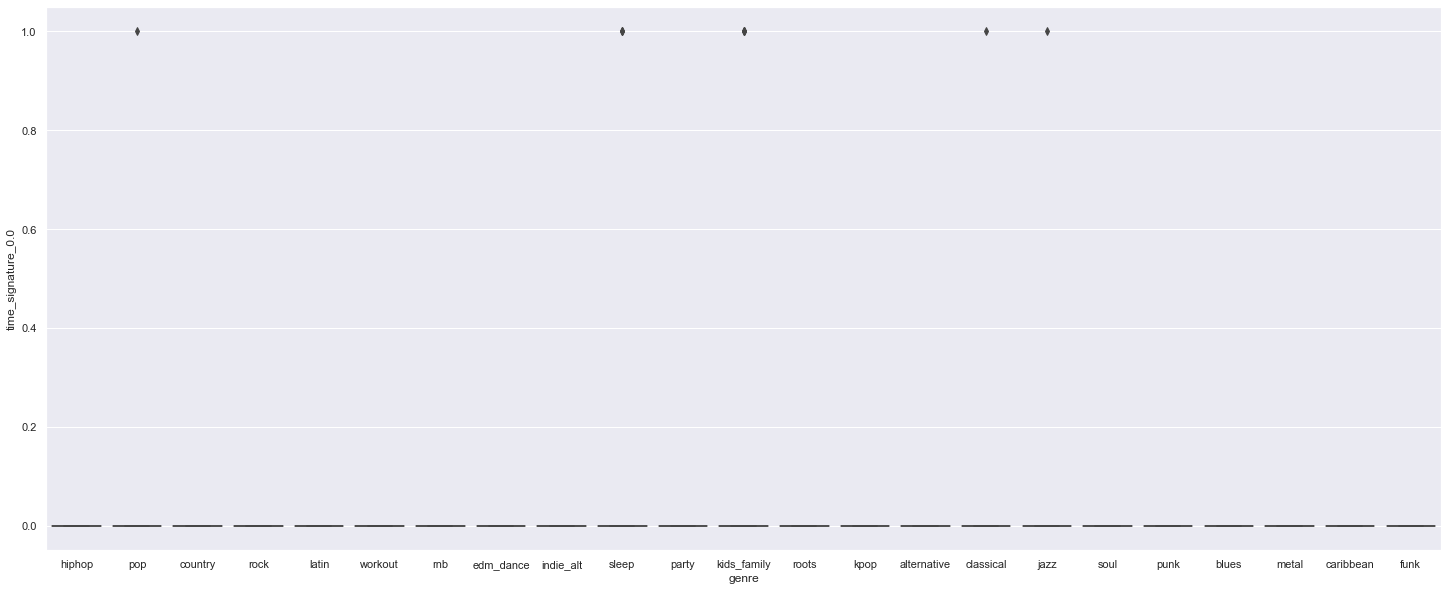

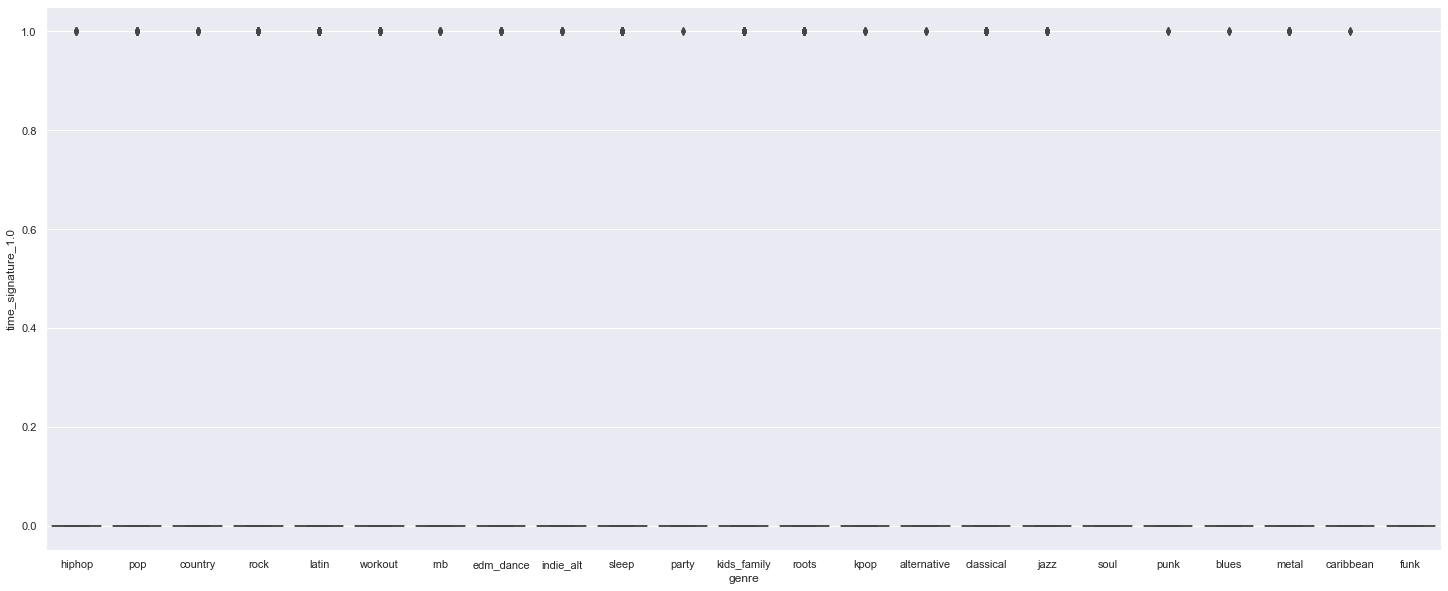

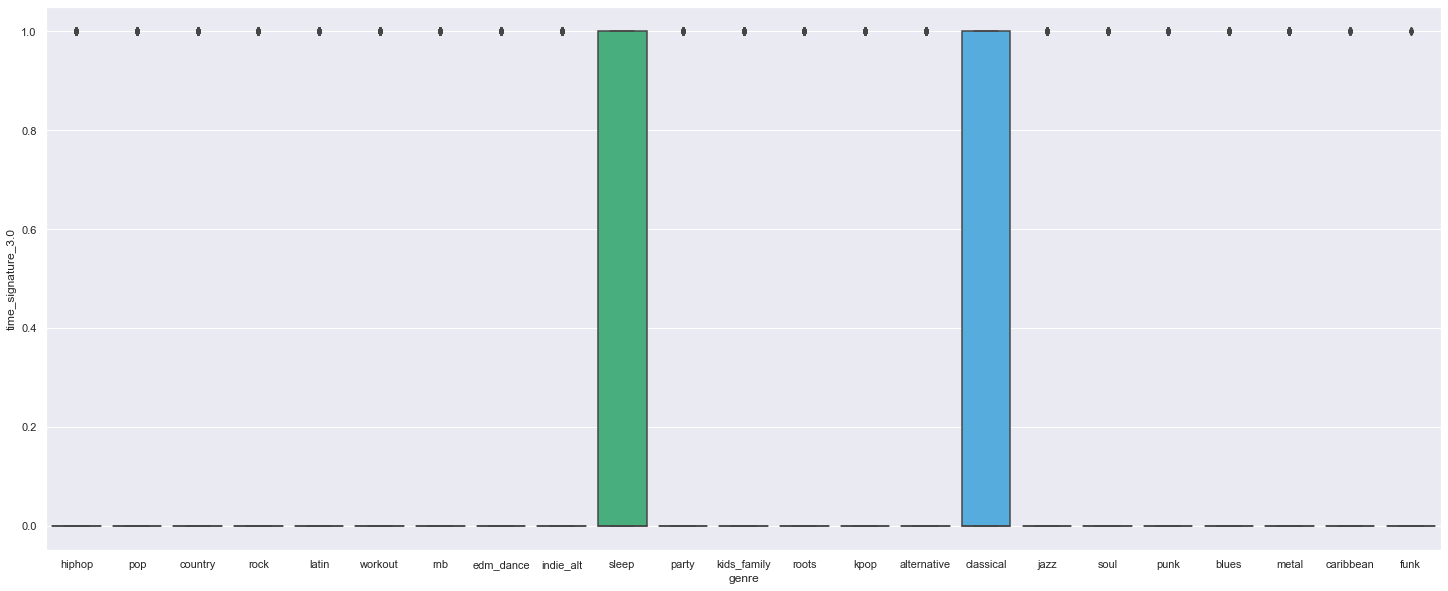

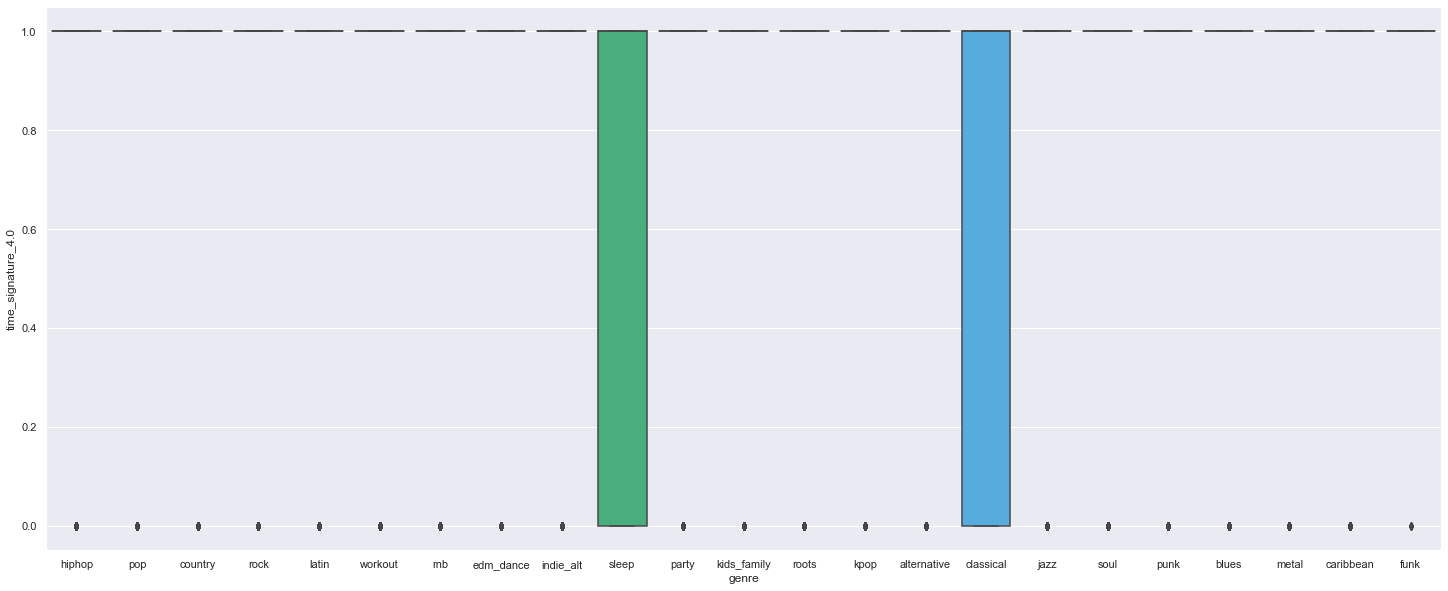

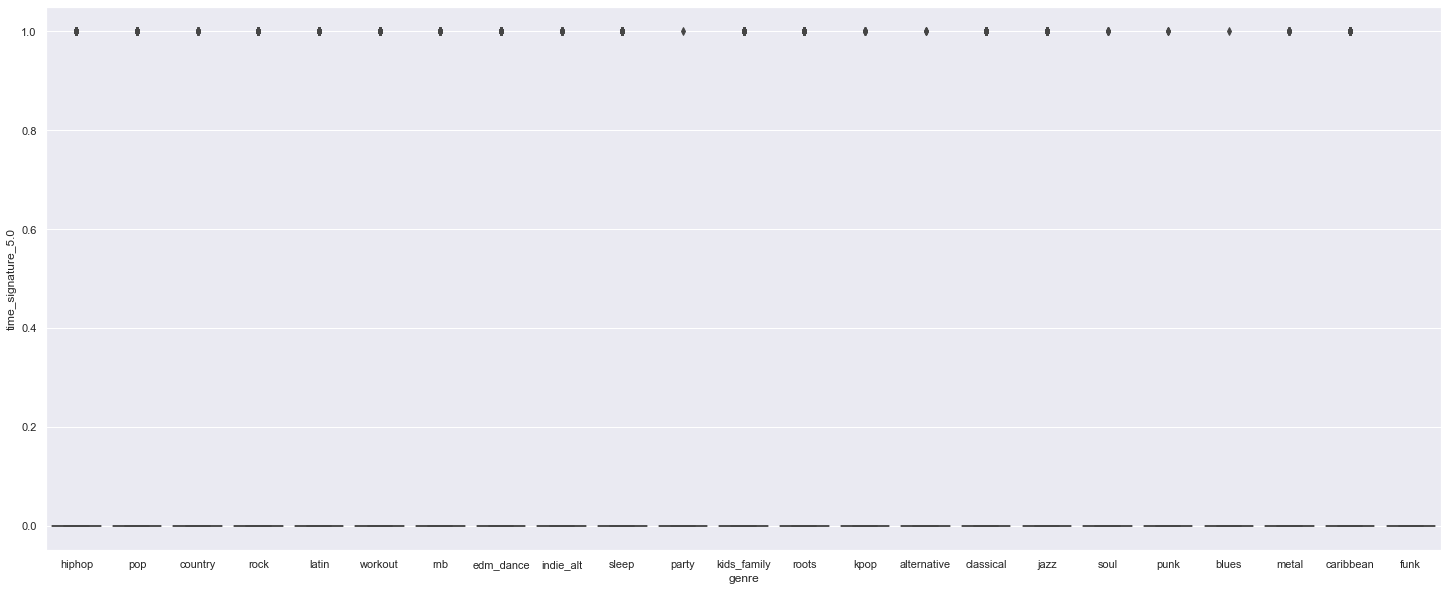

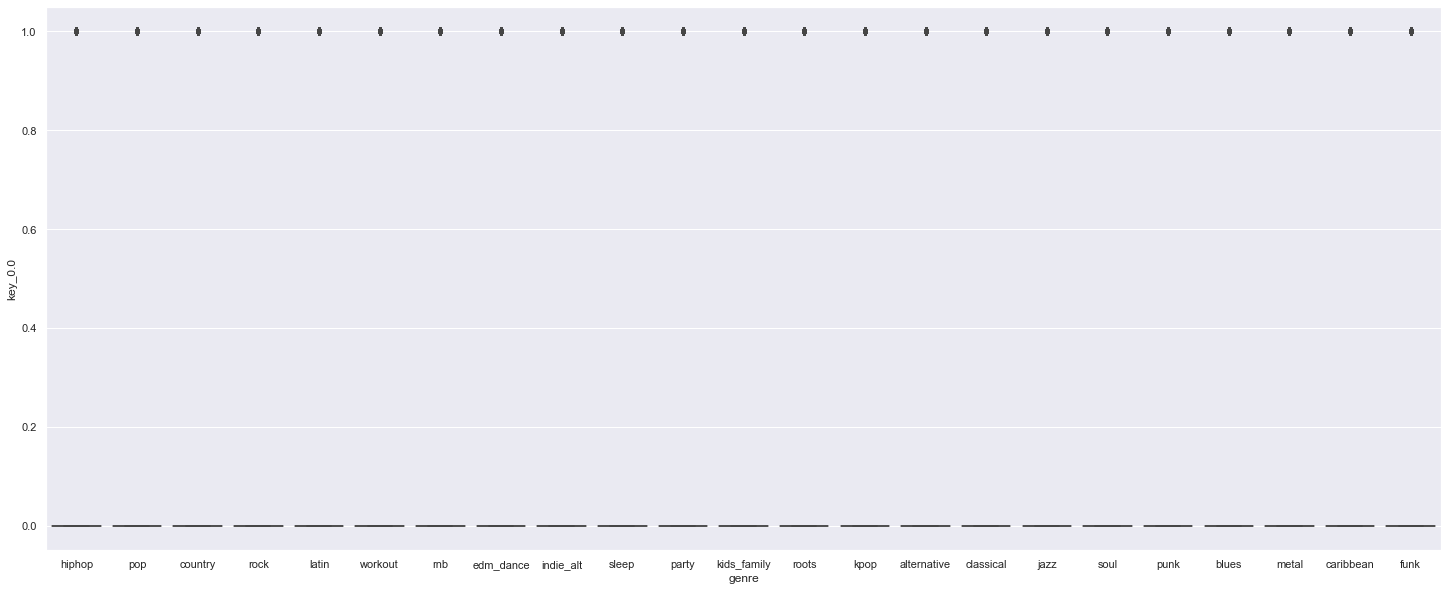

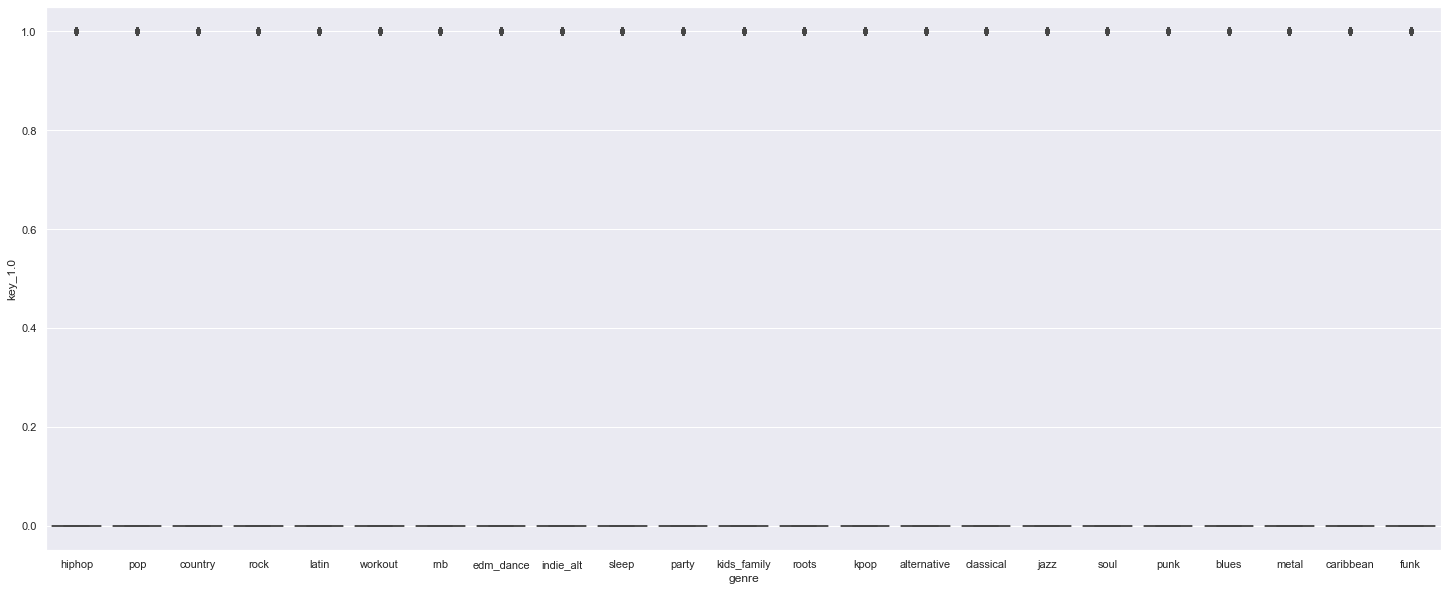

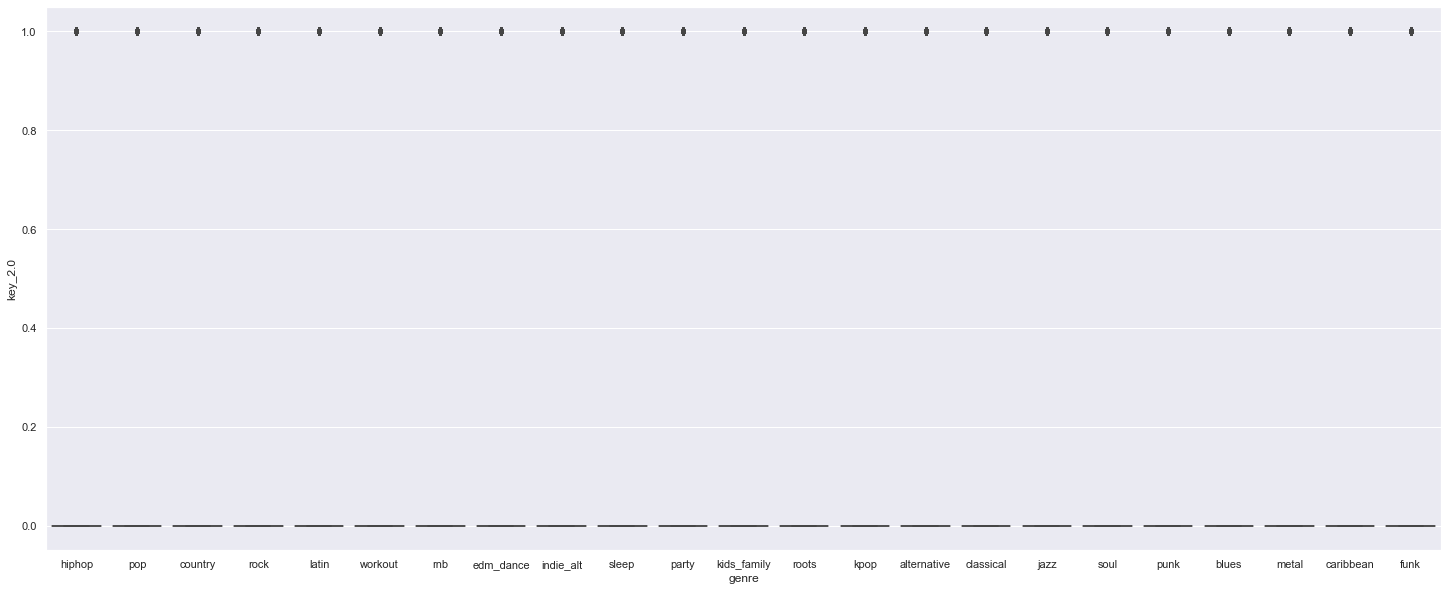

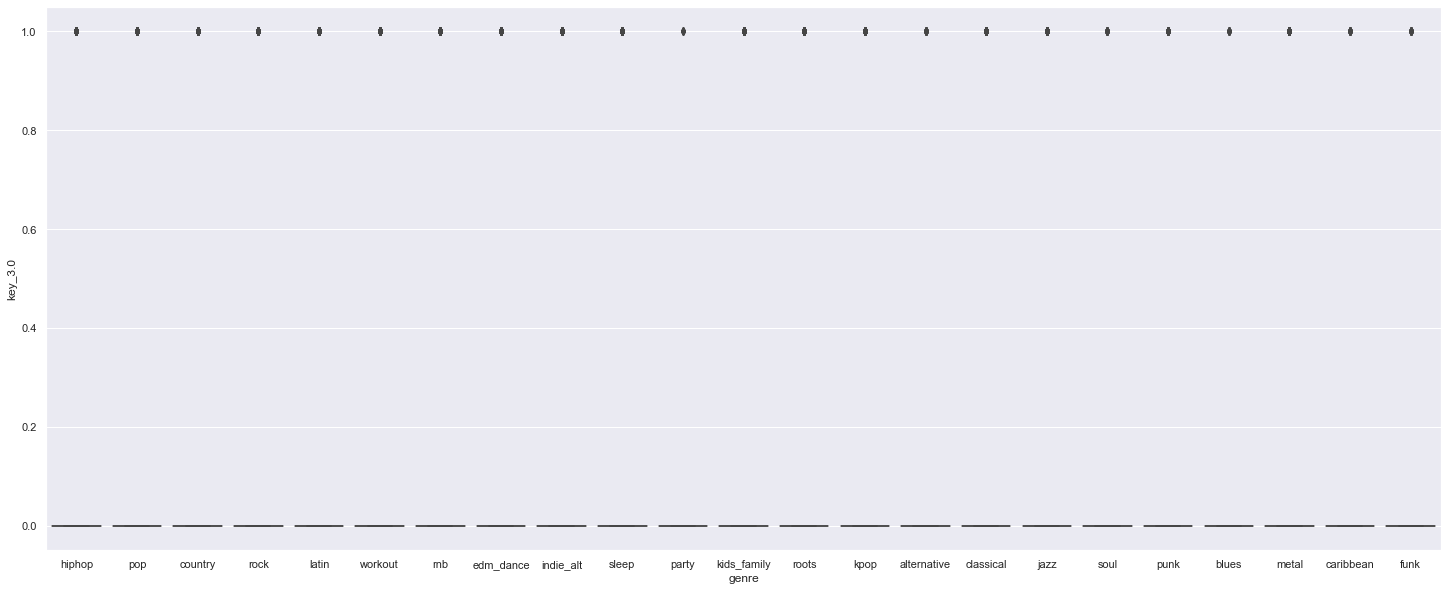

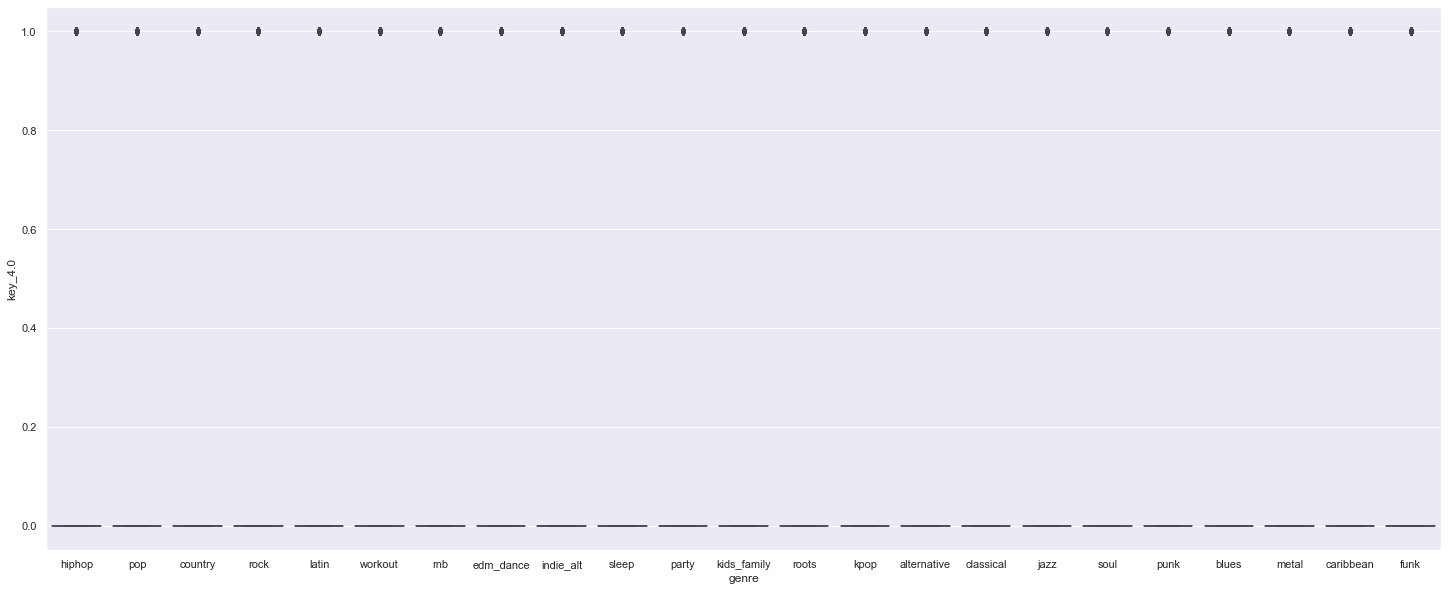

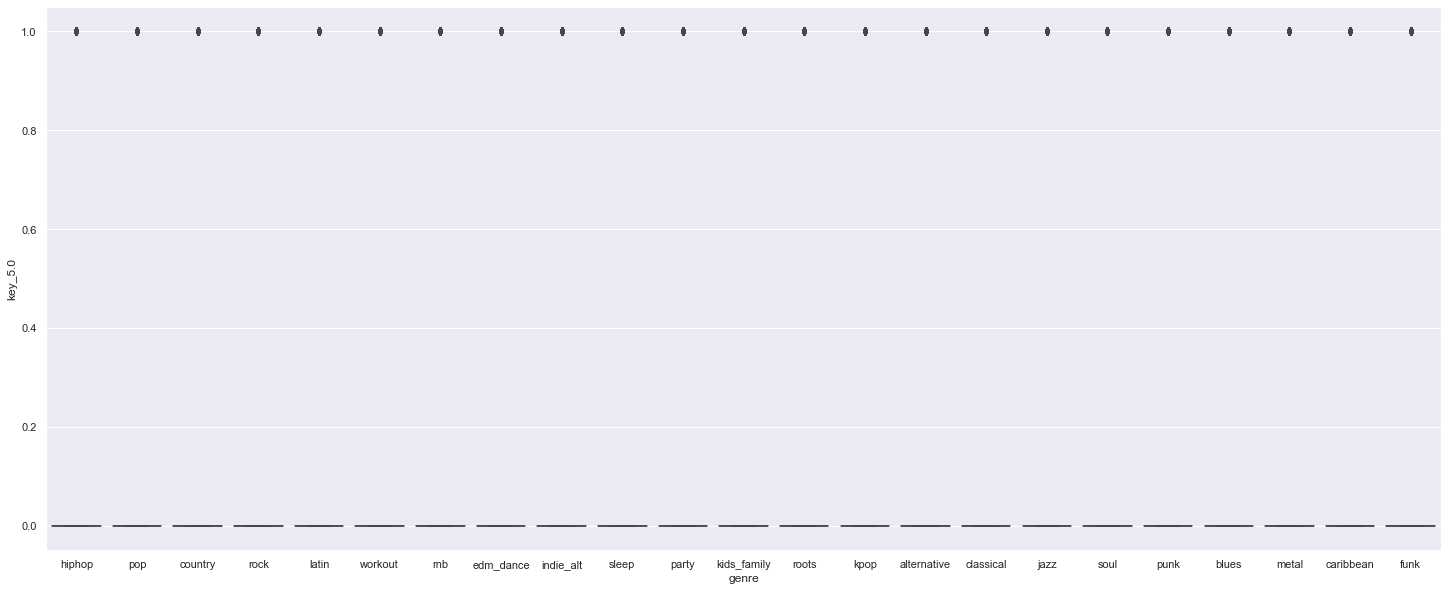

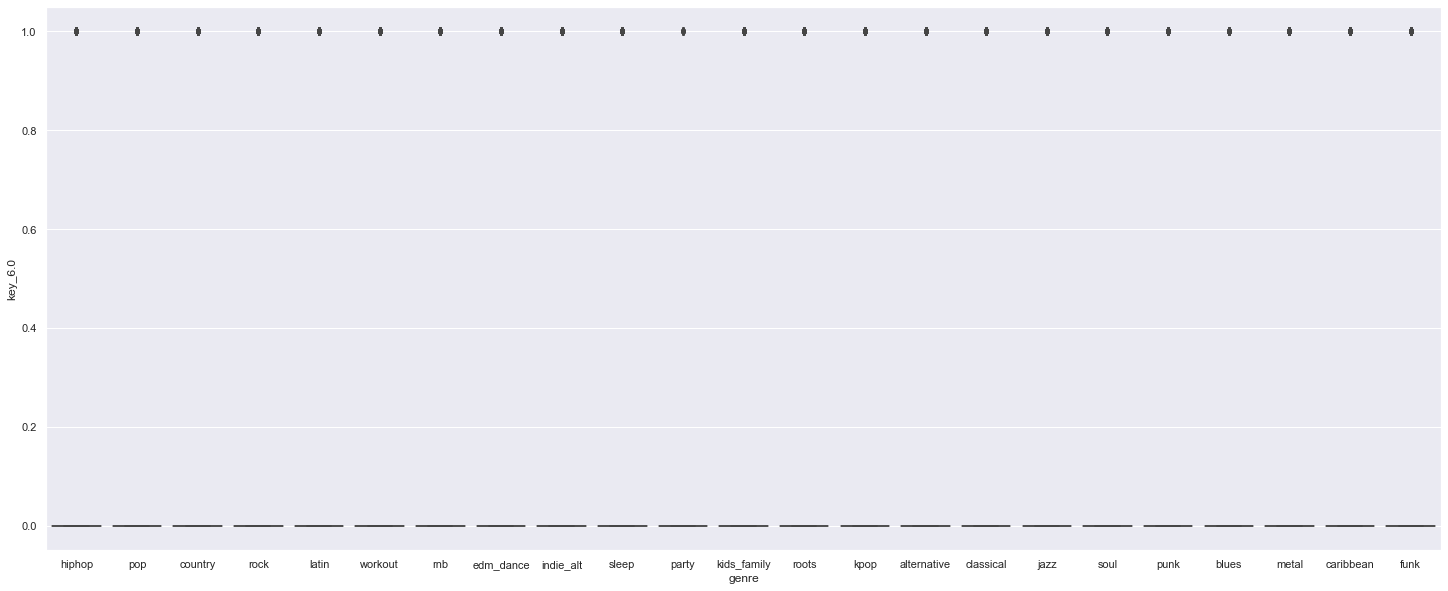

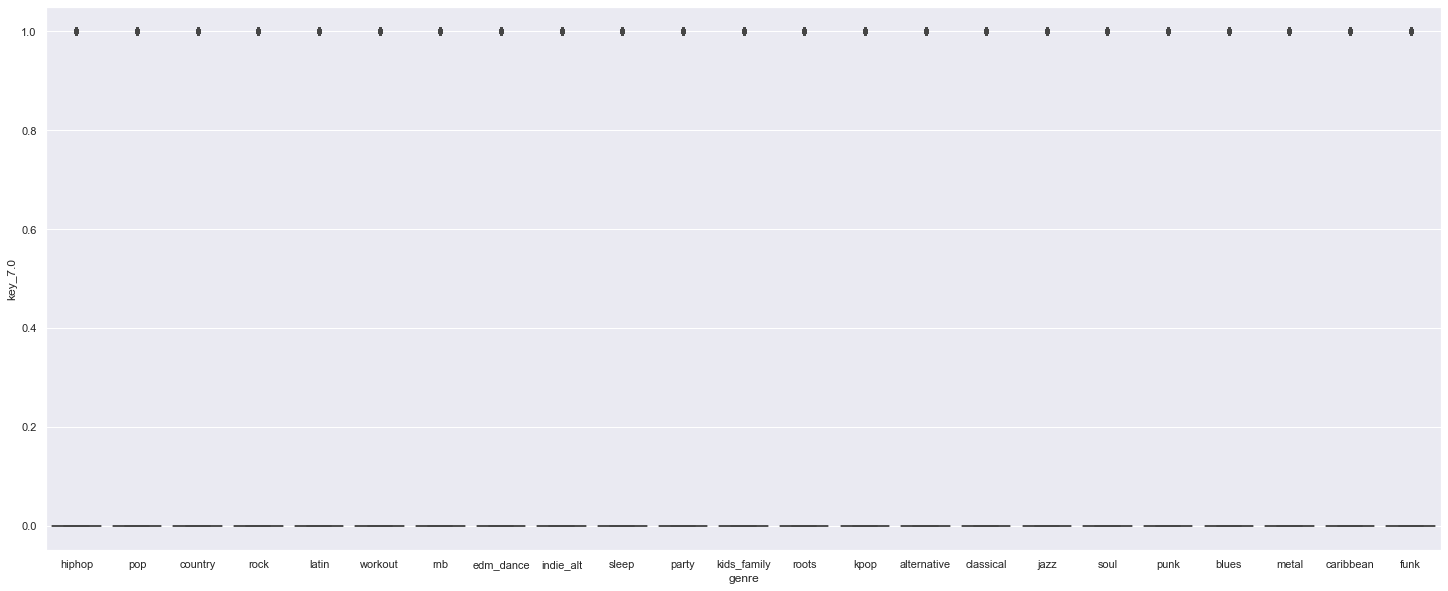

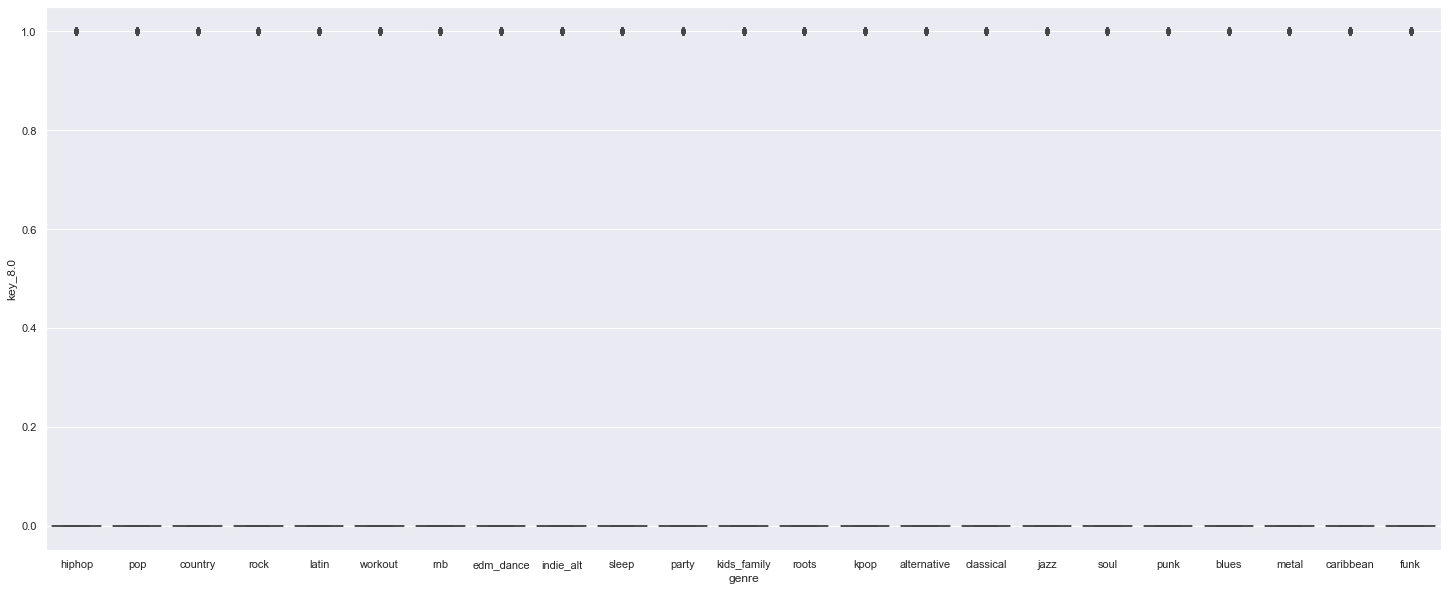

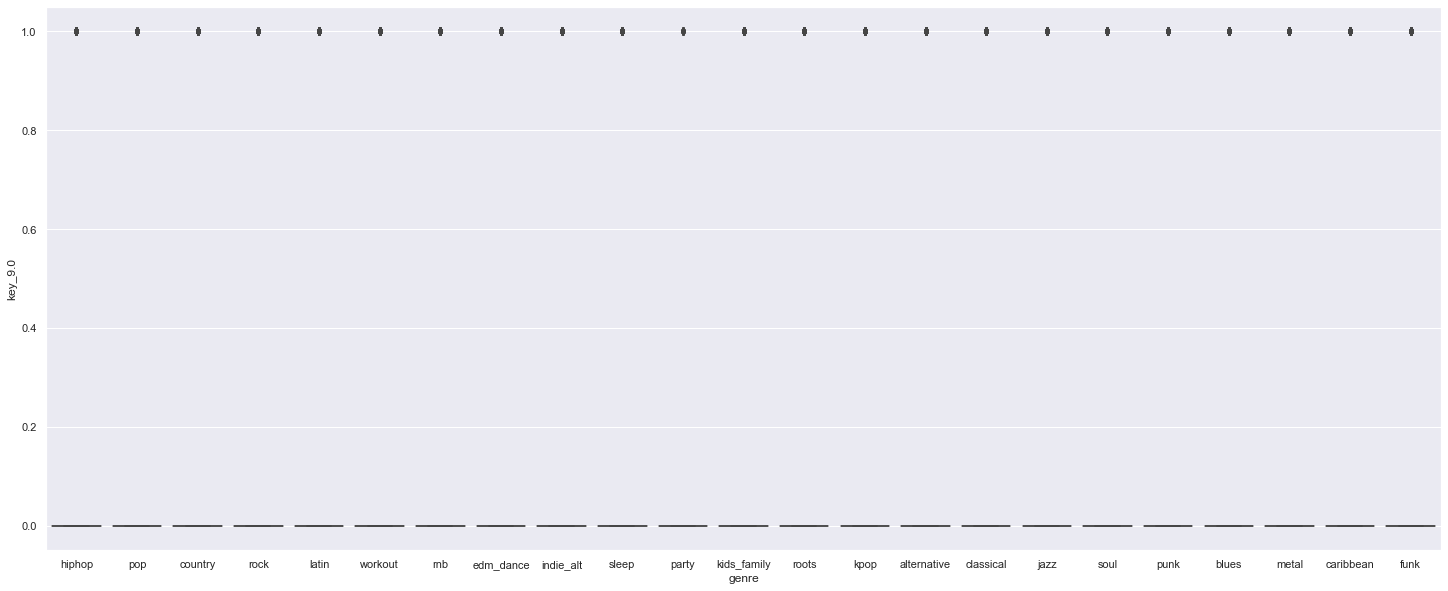

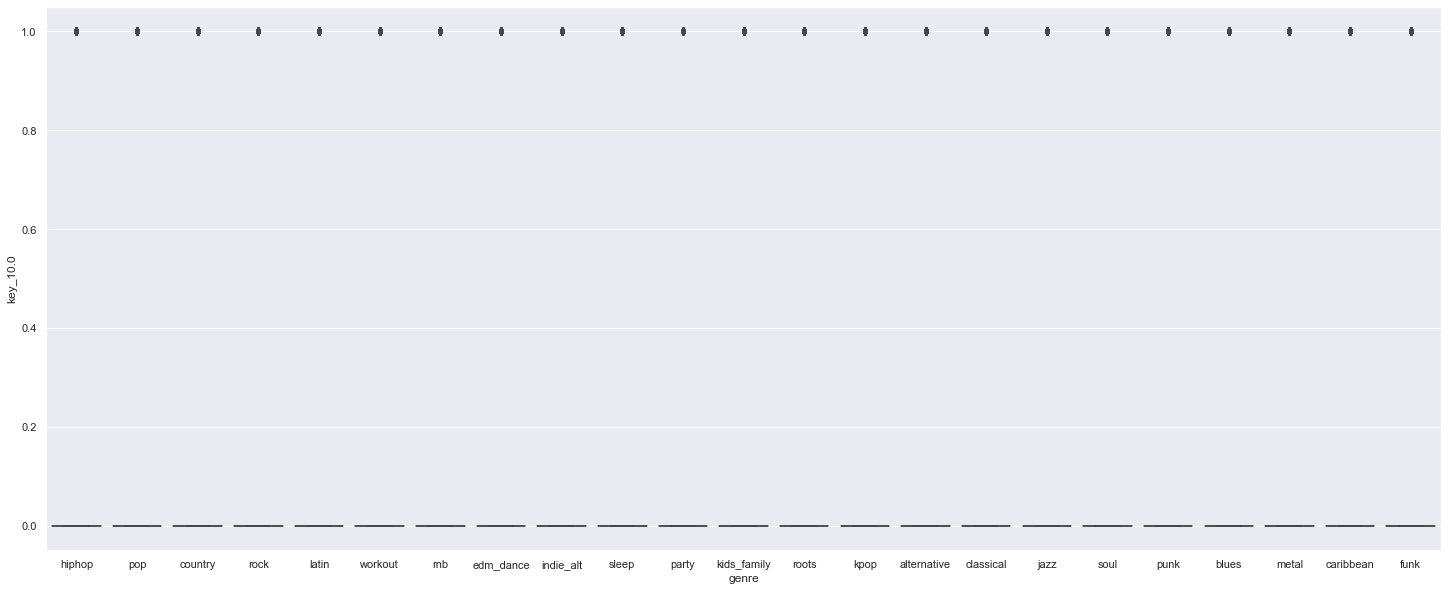

In [30]:
for feature in features.columns:
    sns.set(rc={'figure.figsize':(25,10)})
    plt.show(sns.boxplot(x='genre', y=feature, data=new_df,))

    

In [31]:
features_df = pd.concat([new_df.iloc[:,1:10],new_df.iloc[:,17:35],new_df.iloc[:,11]],axis=1)
features_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,mode_0.0,...,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,key_7.0,key_8.0,key_9.0,key_10.0,genre
0,0.868,0.638,-7.746,0.0736,0.14600,0.056500,0.0931,0.459,126.030,0,...,1,0,0,0,0,0,0,0,0,hiphop
1,0.880,0.575,-6.091,0.1630,0.41500,0.000000,0.1090,0.671,120.031,0,...,0,0,0,0,1,0,0,0,0,hiphop
2,0.688,0.647,-7.258,0.1900,0.00815,0.000017,0.0950,0.195,88.834,0,...,1,0,0,0,0,0,0,0,0,hiphop
3,0.809,0.545,-6.678,0.0735,0.39200,0.000000,0.1510,0.244,97.008,0,...,0,0,0,0,0,1,0,0,0,hiphop
4,0.837,0.364,-11.713,0.2760,0.14900,0.000000,0.2710,0.463,123.984,0,...,0,0,0,0,0,0,1,0,0,hiphop


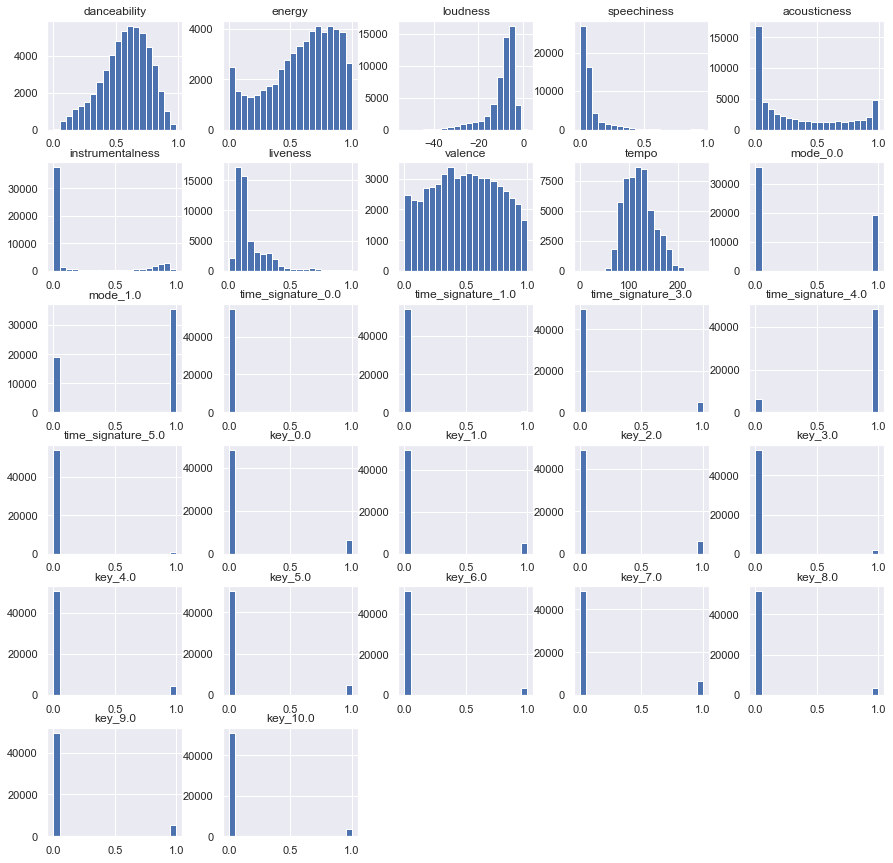

In [32]:
features_df.hist(bins=20, figsize=(15,15))
plt.show()

<AxesSubplot:xlabel='speechiness'>

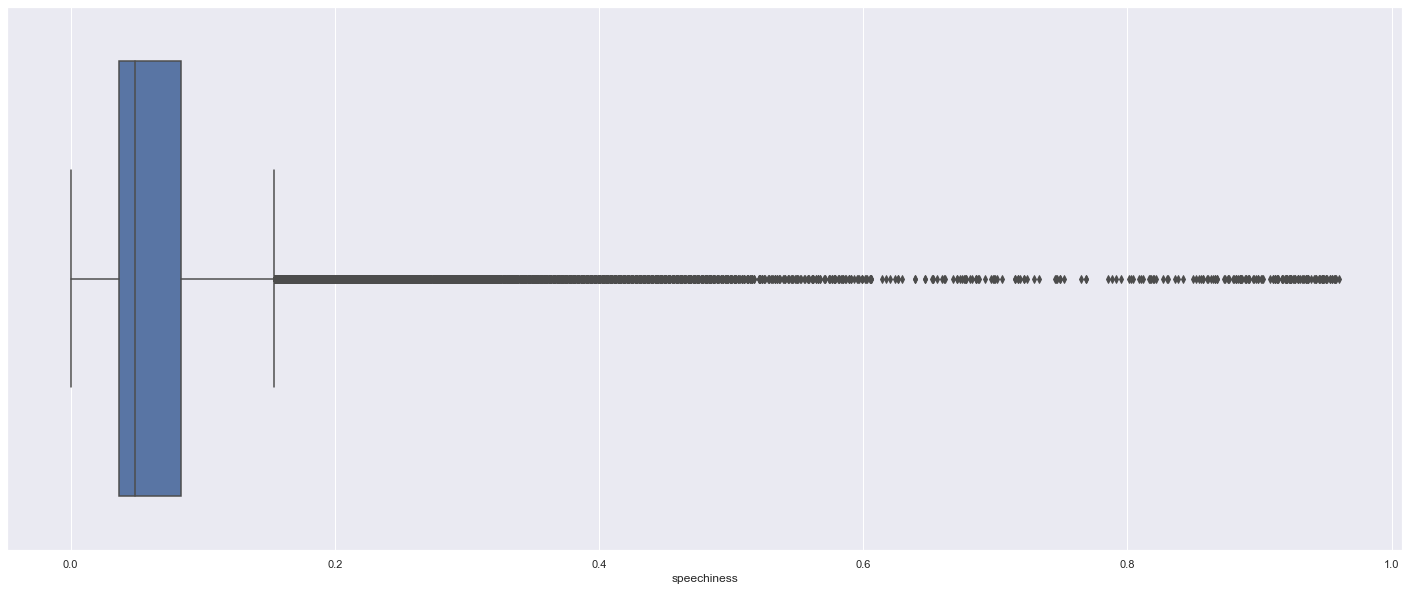

In [33]:
sns.boxplot(x=features_df['speechiness'])

<AxesSubplot:xlabel='loudness'>

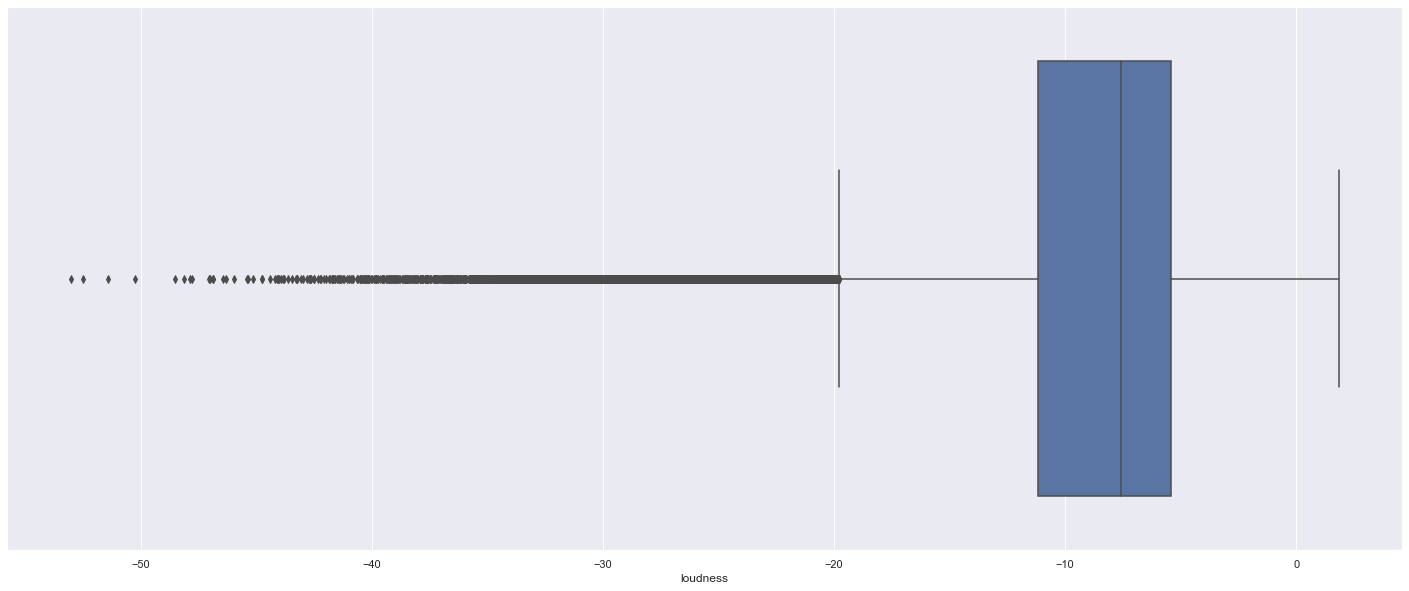

In [34]:
sns.boxplot(x=features_df['loudness'])

<AxesSubplot:xlabel='liveness'>

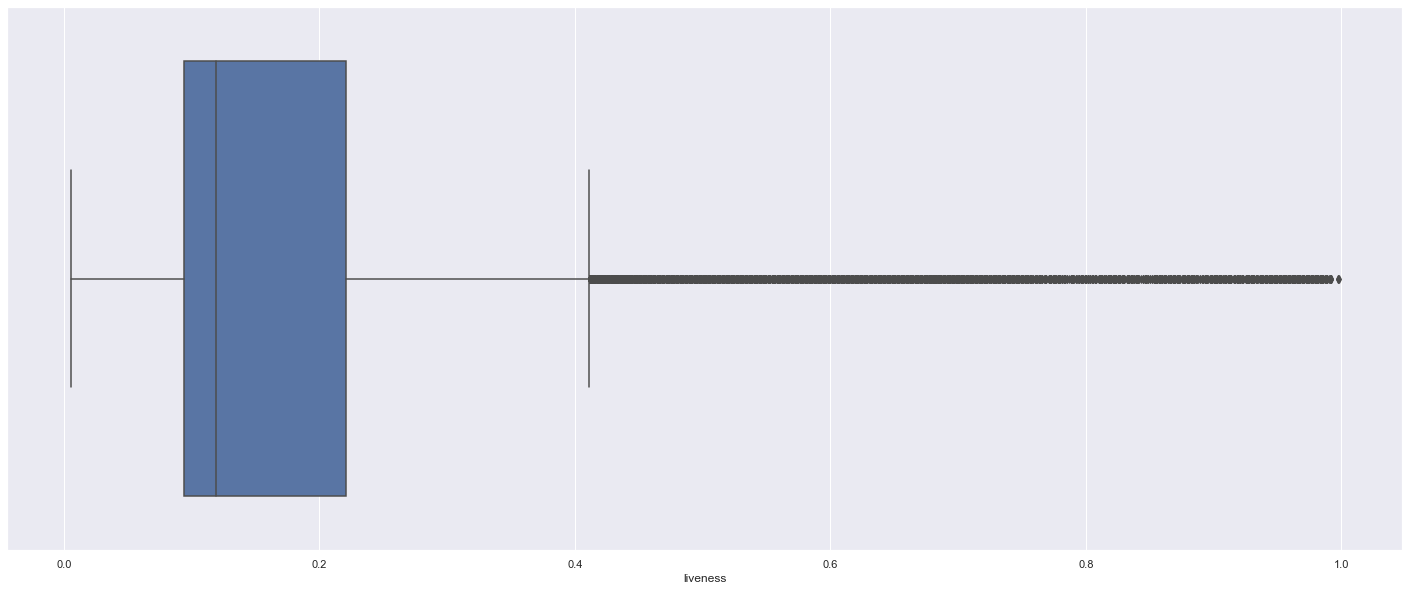

In [35]:
sns.boxplot(x=features_df['liveness'])

<AxesSubplot:xlabel='acousticness'>

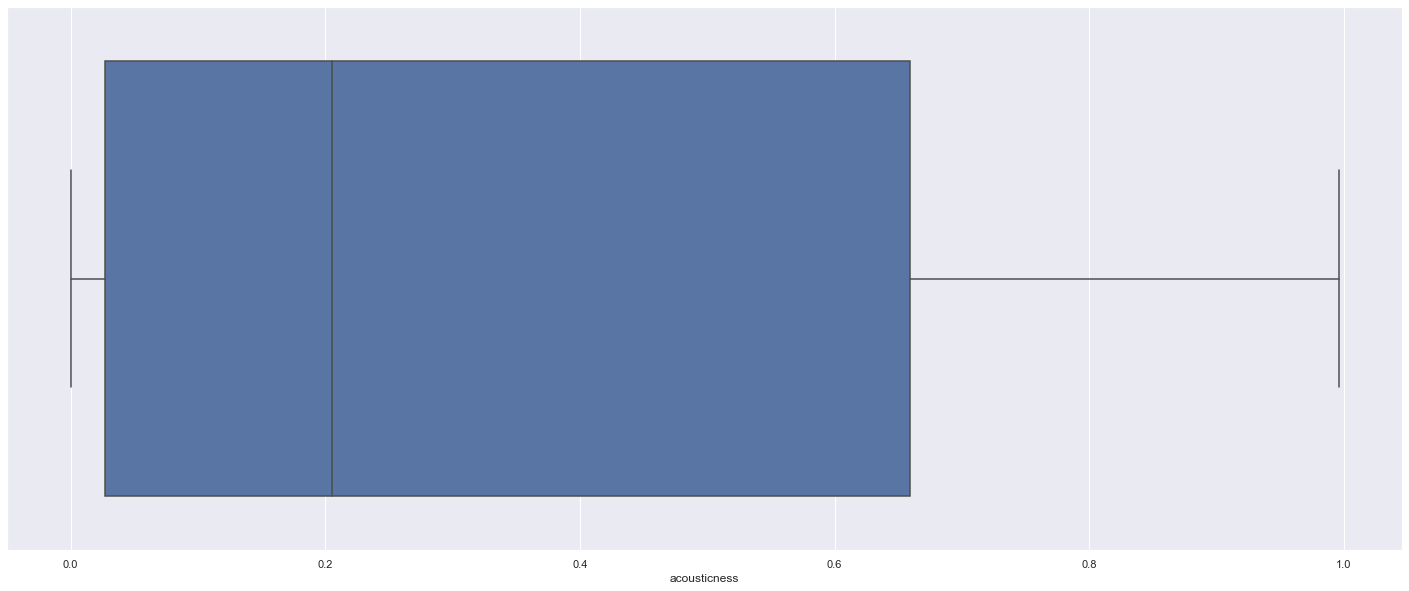

In [36]:
sns.boxplot(x=features_df['acousticness'])

In [37]:
# features_df = features_df[np.abs(features_df.speechiness-features_df.speechiness.mean()) <= (3*features_df.speechiness.std())]
# features_df = features_df[np.abs(features_df.loudness-features_df.loudness.mean()) <= (3*features_df.loudness.std())]
# features_df = features_df[np.abs(features_df.liveness-features_df.liveness.mean()) <= (3*features_df.liveness.std())]
# features_df


In [38]:
# count_song_df.describe()

In [39]:


genre_label_dict = {}
counter = 0
for genre in new_df['genre'].unique():
    if genre not in genre_label_dict:
        genre_label_dict[genre]=counter
        counter+=1
    else:
        continue
genre_label_dict
    
    
for genre_type in new_df['genre'].unique():
    new_df.loc[new_df.genre==genre_type,"class"]=genre_label_dict[genre_type]

In [40]:

new_df['class']=new_df['class'].astype(int)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54766 entries, 0 to 54765
Data columns (total 59 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   song_name           54766 non-null  object 
 1   danceability        54766 non-null  float64
 2   energy              54766 non-null  float64
 3   loudness            54766 non-null  float64
 4   speechiness         54766 non-null  float64
 5   acousticness        54766 non-null  float64
 6   instrumentalness    54766 non-null  float64
 7   liveness            54766 non-null  float64
 8   valence             54766 non-null  float64
 9   tempo               54766 non-null  float64
 10  duration_mins       54766 non-null  float64
 11  genre               54766 non-null  object 
 12  playlist_name       54766 non-null  object 
 13  playlist_id         54766 non-null  object 
 14  date_pulled         54766 non-null  object 
 15  artist              54766 non-null  object 
 16  clas

In [41]:
X=pd.concat([new_df.iloc[:,1:10],new_df.iloc[:,17:35]],axis=1)
y= new_df['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

X_train_scaled=pd.DataFrame(X_train_scaled,columns = X_train.columns)


In [42]:
#random forest baseline

X=pd.concat([new_df.iloc[:,1:10],new_df.iloc[:,17:35]],axis=1)
y= new_df['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

X_train_scaled=pd.DataFrame(X_train_scaled,columns = X_train.columns)



from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
scores_rf_base = np.mean(cross_val_score(rf_classifier,X_train,y_train,cv=10,))
                                 
print(scores_rf_base)



0.42988220054421544


In [43]:
#random forest bootstrapped 

#BEST MODEL

X=pd.concat([new_df.iloc[:,1:10],new_df.iloc[:,17:35]],axis=1)
y= new_df['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

X_train_scaled=pd.DataFrame(X_train_scaled,columns = X_train.columns)


#random forest bootstrap
from sklearn.ensemble import RandomForestClassifier
rf_classifier_b = RandomForestClassifier(bootstrap=True,random_state=13)
rf_classifier_b.fit(X_train, y_train)
rf_predictions_b = rf_classifier_b.predict(X_test)


print(f'Model train Score is {rf_classifier_b.score(X_train, y_train)}')
print(f'Model test Score is {rf_classifier_b.score(X_test, y_test)}')




Model train Score is 0.9996576280471103
Model test Score is 0.43673543910900126


In [44]:
#random forest weighted +bootstrapped 
#bootstrapped w/o weighting out performed 

X=pd.concat([new_df.iloc[:,1:10],new_df.iloc[:,17:35]],axis=1)
y= new_df['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

X_train_scaled=pd.DataFrame(X_train_scaled,columns = X_train.columns)


from sklearn.ensemble import RandomForestClassifier
rf_classifier_wb = RandomForestClassifier(bootstrap=True,random_state=13,class_weight='balanced')
rf_classifier_wb.fit(X_train, y_train)
rf_predictions_wb = rf_classifier_wb.predict(X_test)

rf_classifier_wb.score(X_test, y_test)


0.4353660763191528

In [45]:
#logistic regression model
#balancing classes weakened model

X=pd.concat([new_df.iloc[:,1:10],new_df.iloc[:,17:35]],axis=1)
y= new_df['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

X_train_scaled=pd.DataFrame(X_train_scaled,columns = X_train.columns)



model = OneVsRestClassifier(LogisticRegression(max_iter=1000,multi_class='ovr',solver='liblinear'))
model.fit(X_train_scaled,y_train)
scores_log = cross_val_score(model,X_train_scaled,y_train,cv=10,scoring='accuracy')
print(f'coefficient array:"\n"{model.coef_}')
print(f'intercept array: "\n"{model.intercept_}')
print(f'model score: "\n" {np.mean(scores_log)}')
# proba_df['actual']=y_test



coefficient array:"
"[[ 1.09494132e+00 -4.79960152e-01  5.13572683e-01  6.68911713e-01
  -8.06472942e-01 -1.40147890e+00  9.68528019e-02 -4.85222799e-01
  -1.37741578e-01  8.67574812e-02 -8.67574812e-02 -1.95262771e-02
   3.71445574e-02 -2.52701979e-01  1.75800015e-01  1.05522462e-01
  -4.03523834e-02  9.57892885e-02  4.13098221e-02 -8.11733871e-02
  -3.63342206e-02 -5.22607357e-03  7.80842182e-03 -8.72430260e-02
   1.38200752e-02 -5.10553789e-02  5.57396880e-02]
 [ 3.81903486e-01 -9.29410395e-01  1.30654907e+00 -1.57943187e-01
  -1.64807613e-01 -1.09589316e+00 -4.61775961e-02 -2.32291122e-01
  -1.51844214e-02 -3.96853222e-02  3.96853222e-02  2.83828094e-02
   1.64317604e-02 -1.14435709e-01  7.55975236e-02  5.42510674e-02
  -3.17333986e-02  2.23599267e-02 -7.58698099e-02 -2.25556964e-03
  -5.31743192e-02 -2.75690033e-02  1.07695123e-02 -7.95922067e-02
  -1.03267966e-02 -5.91653699e-02 -8.07962202e-02]
 [-2.14277067e-01 -8.33266537e-02  1.10440466e-01 -1.58796986e+00
  -5.25672582e-02 -

/Users/nickpondok/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)
/Users/nickpondok/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute intercept_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


In [46]:
#logistic regression model with weighted balanced classes 

weighted_model = OneVsRestClassifier(LogisticRegression(max_iter=1000,multi_class='ovr', solver='liblinear',class_weight='balanced'))
weighted_model.fit(X_train_scaled,y_train)

scores_log_w = cross_val_score(weighted_model,X_train_scaled,y_train,cv=10,scoring='accuracy')

print(f'coefficient array:"\n"{weighted_model.coef_}')
print(f'intercept array: "\n"{weighted_model.intercept_}')
print(f'model score: "\n" {np.mean(scores_log_w)}')
# proba_df['actual']=y_test

coefficient array:"
"[[ 1.19608728e+00 -6.25405922e-01  4.79797476e-01  1.06187599e+00
  -6.51168358e-01 -1.20982603e+00  1.54188098e-01 -5.98237155e-01
  -8.62945270e-02  1.07957632e-01 -1.07957632e-01 -5.47503028e-02
   3.62768573e-02 -1.16631154e-01  5.50615633e-02  1.06189377e-01
   2.04115656e-03  1.51776945e-01  4.13571866e-02 -4.91994201e-02
  -3.78121235e-02  2.49330182e-02  2.11760993e-02  3.05914737e-02
   5.82700390e-02 -6.29917836e-03  6.59000564e-02]
 [ 4.37372640e-01 -9.98529762e-01  1.42798763e+00 -1.23270558e-01
  -1.62246746e-01 -1.04926234e+00 -5.74324621e-02 -2.38396050e-01
  -1.58865864e-02 -4.56020334e-02  4.56020334e-02  1.97116402e-02
   2.01382757e-02 -1.04043635e-01  6.94040660e-02  4.44503089e-02
  -3.10347716e-02  3.29625466e-02 -7.99764955e-02  1.13086559e-03
  -6.83293442e-02 -2.85472942e-02  1.41552689e-02 -6.86636275e-02
  -1.96599643e-02 -5.24315810e-02 -7.71913721e-02]
 [-2.69889928e-01 -2.00973340e-01  1.99514167e-01 -1.23282130e+00
  -1.21840643e-02 -

/Users/nickpondok/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)
/Users/nickpondok/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute intercept_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


In [47]:
#classification report for weighted and not weighted log reg
y_predicted = model.predict(X_train_scaled)
y_pred_weighted = weighted_model.predict(X_train_scaled)

print(classification_report(y_train,y_predicted))

print(classification_report(y_train,y_pred_weighted))





              precision    recall  f1-score   support

           0       0.43      0.47      0.45      1786
           1       0.23      0.08      0.12      2616
           2       0.28      0.17      0.21      2987
           3       0.33      0.63      0.43      4738
           4       0.31      0.67      0.42      6555
           5       0.05      0.00      0.00      1801
           6       0.22      0.01      0.03      1007
           7       0.49      0.67      0.56      4392
           8       1.00      0.00      0.00      1409
           9       0.55      0.30      0.39      1137
          10       0.00      0.00      0.00       222
          11       0.35      0.08      0.13      1841
          12       0.33      0.27      0.30      2922
          13       0.30      0.03      0.05      1249
          14       0.00      0.00      0.00       353
          15       0.60      0.88      0.72      3241
          16       0.32      0.18      0.23      1722
          17       0.00    

/Users/nickpondok/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nickpondok/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nickpondok/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
#KNN model weight uniformed


X=pd.concat([new_df.iloc[:,1:10],new_df.iloc[:,17:35]],axis=1)
y= new_df['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

X_train_scaled=pd.DataFrame(X_train_scaled,columns = X_train.columns)


knn = KNeighborsClassifier(n_neighbors=115,weights ='uniform')

std_scale = StandardScaler()
X_scaled = std_scale.fit_transform(X)

scores_knnbase = cross_val_score(knn,X_scaled,y,cv=10,scoring='accuracy')

# knn.fit(X_train,y_train)
# knny_pred=knn.predict(X_test)

print(scores_knnbase.mean())

0.3471502883497268


In [49]:
#KNN model weight distance


X=pd.concat([new_df.iloc[:,1:10],new_df.iloc[:,17:35]],axis=1)
y= new_df['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

X_train_scaled=pd.DataFrame(X_train_scaled,columns = X_train.columns)


knn = KNeighborsClassifier(n_neighbors=115,weights ='distance')

std_scale = StandardScaler()
X_scaled = std_scale.fit_transform(X)

scores = cross_val_score(knn,X_scaled,y,cv=10,scoring='accuracy')

print(scores.mean())

0.353888053408283


In [50]:
#final model to use will be random forest with bootstrapping

In [51]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54766 entries, 0 to 54765
Data columns (total 59 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   song_name           54766 non-null  object 
 1   danceability        54766 non-null  float64
 2   energy              54766 non-null  float64
 3   loudness            54766 non-null  float64
 4   speechiness         54766 non-null  float64
 5   acousticness        54766 non-null  float64
 6   instrumentalness    54766 non-null  float64
 7   liveness            54766 non-null  float64
 8   valence             54766 non-null  float64
 9   tempo               54766 non-null  float64
 10  duration_mins       54766 non-null  float64
 11  genre               54766 non-null  object 
 12  playlist_name       54766 non-null  object 
 13  playlist_id         54766 non-null  object 
 14  date_pulled         54766 non-null  object 
 15  artist              54766 non-null  object 
 16  clas

In [52]:
#squaring speechiness (did not work)

X2 = new_df.copy()

X2['speech_squared'] = X2['speechiness'] ** 2

X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54766 entries, 0 to 54765
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   song_name           54766 non-null  object 
 1   danceability        54766 non-null  float64
 2   energy              54766 non-null  float64
 3   loudness            54766 non-null  float64
 4   speechiness         54766 non-null  float64
 5   acousticness        54766 non-null  float64
 6   instrumentalness    54766 non-null  float64
 7   liveness            54766 non-null  float64
 8   valence             54766 non-null  float64
 9   tempo               54766 non-null  float64
 10  duration_mins       54766 non-null  float64
 11  genre               54766 non-null  object 
 12  playlist_name       54766 non-null  object 
 13  playlist_id         54766 non-null  object 
 14  date_pulled         54766 non-null  object 
 15  artist              54766 non-null  object 
 16  clas

In [53]:
#random forest w/ bootstrapping tuning ideas 
#mess with estimators and max features 


#attempting to square speechiness (did not work)


X=pd.concat([X2.iloc[:,1:10],X2.iloc[:,17:35],X2.iloc[:,-1:]],axis=1)
y= X2['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

X_train_scaled=pd.DataFrame(X_train_scaled,columns = X_train.columns)


#random forest bootstrap
from sklearn.ensemble import RandomForestClassifier
rf_classifier_speech = RandomForestClassifier(bootstrap=True,random_state=13)
rf_classifier_speech.fit(X_train, y_train)
rf_predictions_speech = rf_classifier_speech.predict(X_test)

print(f'Model Score is {rf_classifier_speech.score(X_test, y_test)}')


Model Score is 0.43573123972977906


In [254]:
# import collections
# #find best number of estimators

# X=pd.concat([new_df.iloc[:,1:10],new_df.iloc[:,17:35]],axis=1)
# y= new_df['class']


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# est_range =list(range(50,101))
# best_scores= {}
# for est in est_range:
#     rfc = RandomForestClassifier(bootstrap=True,random_state=13,n_estimators=est)
#     rfc.fit(X_train, y_train)
#     rfc_preds = rfc.predict(X_test)
#     best_scores[est]=rfc.score(X_test, y_test)


# print(best_scores)


In [ ]:
# X=pd.concat([new_df.iloc[:,1:10],new_df.iloc[:,17:35]],axis=1)
# y= new_df['class']


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# std_scale = StandardScaler()
# X_train_scaled = std_scale.fit_transform(X_train)

# X_train_scaled=pd.DataFrame(X_train_scaled,columns = X_train.columns)



# from sklearn.ensemble import RandomForestClassifier
# rfc = RandomForestClassifier(bootstrap=True,random_state=13,)
# rfc.fit(X_train, y_train)
# rfc_predictions = rfc.predict(X_test)
# scores_rfc = np.mean(cross_val_score(rfc,X_train,y_train,cv=10,))
                                 
# print(scores_rfc)

In [121]:
genres=pd.DataFrame(new_df['genre'])
classes=pd.DataFrame(new_df['class'])
class_genre_df = genres.merge(classes, left_index=True, right_index=True)

class_genre_df.drop_duplicates()

,genre,class
0,hiphop,0
2237,pop,1
5519,country,2
9309,rock,3
15175,latin,4
23379,workout,5
25583,rnb,6
26838,edm_dance,7
32338,indie_alt,8
34131,sleep,9


Text(336.453125, 0.5, 'Truth')

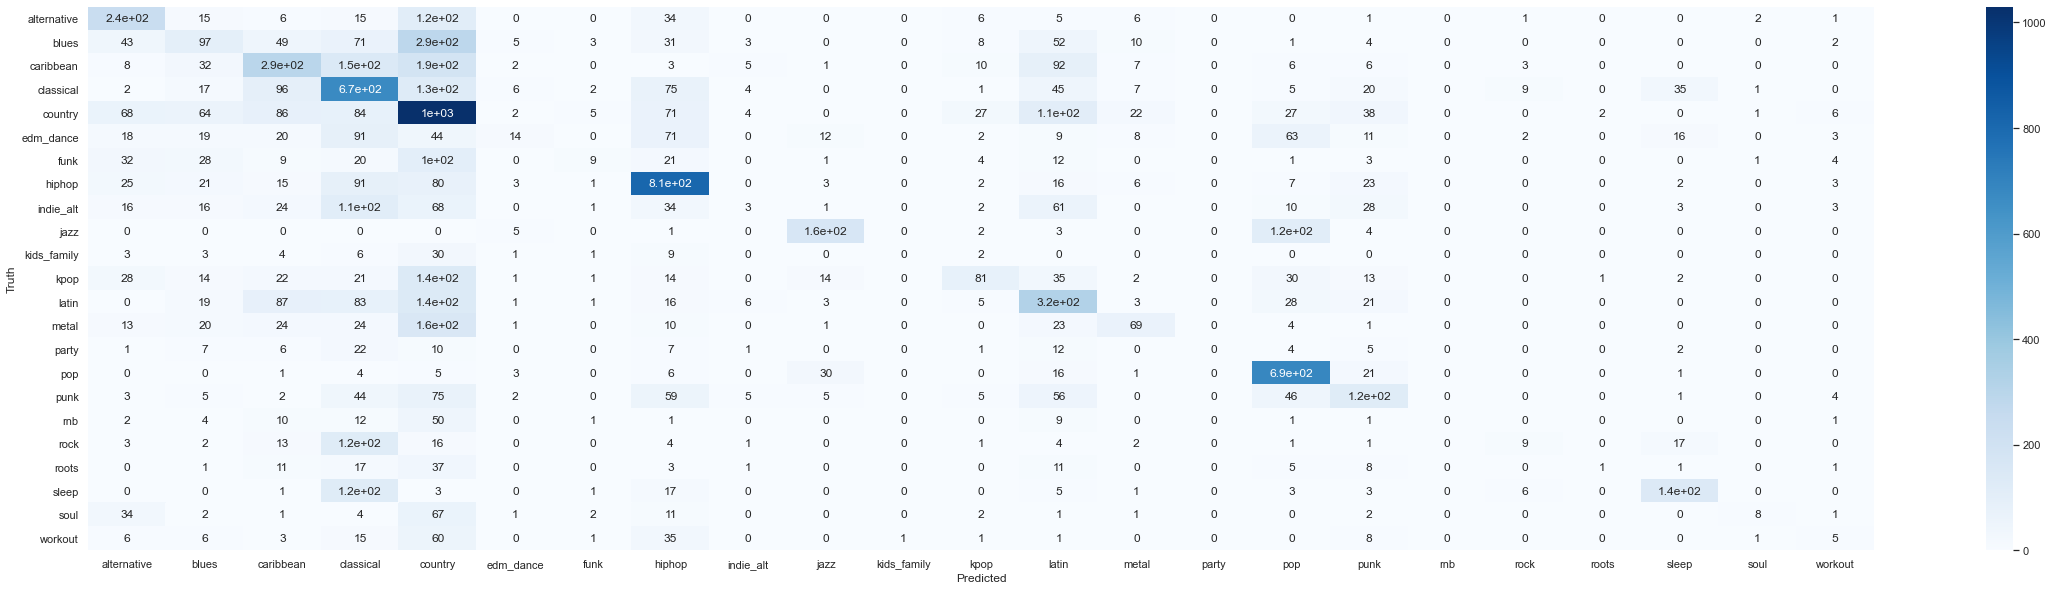

In [57]:
#rf bootstrapped confusion matrix


cm=confusion_matrix(y_test,rf_predictions_b)
sns.set(rc={'figure.figsize':(40,10)})
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=False,
           xticklabels=sorted(new_df['genre'].unique()),
           yticklabels=sorted(new_df['genre'].unique()))
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
#finding best max_features 

# max_feat_default = int(np.sqrt(len(features.columns)))

# max_feat_list =list(range(max_feat_default-5,max_feat_default))

# for feature in max_feat_list:
#     rf_classifier_b = RandomForestClassifier(bootstrap=True,random_state=13,max_features=feature)
#     rf_classifier_b.fit(X_train, y_train)
#     rf_predictions_b = rf_classifier_b.predict(X_test)
#     print(f'Model Score for {estimator} estimators is {rf_classifier_b.score(X_test, y_test)}')
# max_feat_list

In [ ]:
feature_importance=rf_classifier.feature_importances_

indices=np.argsort(feature_importance)
feature_names = X_train.columns

fig = plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)),feature_importance[indices])
plt.yticks(range(len(indices)),[feature_names[c] for c in indices])

In [ ]:
#rf base model score
model_scores = [scores_knnbase.mean(),scores.mean(),np.mean(scores_log_w),np.mean(scores_log),
                scores_rf_base, rf_classifier_b.score(X_test, y_test)]

model_list = ['KNN Base','KNN Distance','LogReg Balanced','LogReg Base','RF Base','RF Boot']

fig = plt.figure(figsize=(8, 6))
plt.bar(model_list,model_scores
       )
plt.ylabel('Model Accuracy',font={'size':20})
plt.xlabel('Model Type',font={'size':20})
plt.xticks(font={'size':10},rotation=45)
plt.yticks(font={'size':10})

In [ ]:
song_num = len(set(new_df['song_name']))
genre_num = len(set(new_df['genre']))
count_song_df = pd.DataFrame(new_df.groupby('genre')['song_name'].count())
               
print(f'There are {song_num} songs in the database')
print(f'There are {genre_num} genres in the database')
display(count_song_df.sort_values('song_name',ascending = True))

In [178]:
#example kendrick lamar 
kendrick=pd.DataFrame(sp.audio_features('https://open.spotify.com/track/6HZILIRieu8S0iqY8kIKhj?si=1f5ed11a010f4e64'))
kendrick

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.638,0.523,1,-6.664,1,0.357,0.00454,0,0.0842,0.422,139.913,audio_features,6HZILIRieu8S0iqY8kIKhj,spotify:track:6HZILIRieu8S0iqY8kIKhj,https://api.spotify.com/v1/tracks/6HZILIRieu8S...,https://api.spotify.com/v1/audio-analysis/6HZI...,185947,4


In [179]:
drop_list = ['type','uri','track_href','analysis_url']
kendrick.drop(drop_list,axis=1, inplace = True)
kendrick = pd.get_dummies(kendrick,columns=['mode','time_signature','key','id'])
kendrick

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,mode_1,time_signature_4,key_1,id_6HZILIRieu8S0iqY8kIKhj
0,0.638,0.523,-6.664,0.357,0.00454,0,0.0842,0.422,139.913,185947,1,1,1,1


In [180]:
X_train.columns


Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'mode_0.0',
       'mode_1.0', 'time_signature_0.0', 'time_signature_1.0',
       'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0',
       'key_0.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0',
       'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0'],
      dtype='object')

In [181]:
kendrick.merge(kendrick_dummy, left_index=True, right_index=True)
kendrick.reset_index(drop=True)
kendrick


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,mode_1,time_signature_4,key_1,id_6HZILIRieu8S0iqY8kIKhj
0,0.638,0.523,-6.664,0.357,0.00454,0,0.0842,0.422,139.913,185947,1,1,1,1


In [182]:
X_train.columns

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'mode_0.0',
       'mode_1.0', 'time_signature_0.0', 'time_signature_1.0',
       'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0',
       'key_0.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0',
       'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0'],
      dtype='object')

In [183]:

kendrick['mode_1.0']=0
kendrick['time_signature_0.0']=0
kendrick['time_signature_1.0']=0
kendrick['time_signature_3.0']=0
kendrick['time_signature_5.0']=0
kendrick['key_0.0']=0
kendrick['key_2.0']=0
kendrick['key_3.0']=0
kendrick['key_4.0']=0
kendrick['key_5.0']=0
kendrick['key_6.0']=0
kendrick['key_7.0']=0
kendrick['key_8.0']=0
kendrick['key_9.0']=0
kendrick['key_10.0']=0

In [184]:
kendrick.drop("duration_ms",axis=1,inplace=True)
kendrick.drop("id_6HZILIRieu8S0iqY8kIKhj",axis=1,inplace=True)
print(kendrick.columns)
print(X_train.columns)

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'mode_1',
       'time_signature_4', 'key_1', 'mode_1.0', 'time_signature_0.0',
       'time_signature_1.0', 'time_signature_3.0', 'time_signature_5.0',
       'key_0.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0', 'key_6.0',
       'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0'],
      dtype='object')
Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'mode_0.0',
       'mode_1.0', 'time_signature_0.0', 'time_signature_1.0',
       'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0',
       'key_0.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0',
       'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0'],
      dtype='object')


In [185]:
rf_classifier_b.predict(kendrick)#predicted hiphop correct

array([0])

In [249]:
beet=pd.DataFrame(sp.audio_features('https://open.spotify.com/track/39l1UORIhuHvUWfxG53tRZ?si=9259f7bc610c43c8'))
beet



,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.539,0.599,3,-10.638,1,0.0483,0.0375,0,0.0754,0.636,167.7,audio_features,39l1UORIhuHvUWfxG53tRZ,spotify:track:39l1UORIhuHvUWfxG53tRZ,https://api.spotify.com/v1/tracks/39l1UORIhuHv...,https://api.spotify.com/v1/audio-analysis/39l1...,290933,4


In [250]:
drop_list = ['type','uri','track_href','analysis_url']
beet.drop(drop_list,axis=1, inplace = True)
beet = pd.get_dummies(beet,columns=['mode','time_signature','key','id'])
beet

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,mode_1,time_signature_4,key_3,id_39l1UORIhuHvUWfxG53tRZ
0,0.539,0.599,-10.638,0.0483,0.0375,0,0.0754,0.636,167.7,290933,1,1,1,1


In [251]:
beet['mode_0.0']=0
beet['time_signature_0.0']=0
beet['time_signature_1.0']=0
beet['time_signature_3.0']=0
beet['time_signature_5.0']=0
beet['key_1.0']=0
beet['key_2.0']=0
beet['key_4.0']=0
beet['key_6.0']=0
beet['key_5.0']=0
beet['key_0.0']=0
beet['key_7.0']=0
beet['key_8.0']=0
beet['key_9.0']=0
beet['key_10.0']=0

In [252]:
beet.drop("duration_ms",axis=1,inplace=True)
beet.drop("id_39l1UORIhuHvUWfxG53tRZ",axis=1,inplace=True)
print(beet.columns)
print(X_train.columns)

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'mode_1',
       'time_signature_4', 'key_3', 'mode_0.0', 'time_signature_0.0',
       'time_signature_1.0', 'time_signature_3.0', 'time_signature_5.0',
       'key_1.0', 'key_2.0', 'key_4.0', 'key_6.0', 'key_5.0', 'key_0.0',
       'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0'],
      dtype='object')
Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'mode_0.0',
       'mode_1.0', 'time_signature_0.0', 'time_signature_1.0',
       'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0',
       'key_0.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0',
       'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0'],
      dtype='object')


In [253]:
rf_classifier_b.predict(beet)

array([17])